# WGAN for cartoon
## 训练
训练模型进行生成二次元图像，也可直接使用预训练模型直接生成，说明博客 https://blog.csdn.net/zhaoguanghe/article/details/103938056

In [1]:
import tensorflow as tf
from tensorflow.keras import layers

D:\Anaconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\framework\dtypes.py:519: 

In [2]:
def generator_model_64():
    model = tf.keras.Sequential()
    model.add(layers.Dense(1*1*100, use_bias=False, input_shape=(100,)))
    model.add(layers.Reshape((1, 1, 100))) # [batch,100]
    assert model.output_shape == (None, 1, 1, 100) # Note: None is the batch size
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(512, 4, 1, padding='valid', use_bias=False))
    assert model.output_shape == (None, 4, 4, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
              
    model.add(layers.Conv2DTranspose(256, 4, 2, padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
              
    model.add(layers.Conv2DTranspose(128, 4, 2, padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
              
    model.add(layers.Conv2DTranspose(64, 4, 2, padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(3, 4, 2, padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

def generator_model_32():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(1*1*100, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Reshape((1, 1, 100))) # [batch,100]
    assert model.output_shape == (None, 1, 1, 100) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(256, 4, 1, padding='valid', use_bias=False))# [1,1,100] [4,4,256]
    assert model.output_shape == (None, 4, 4, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
              
    model.add(layers.Conv2DTranspose(128, 4, 2, padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
              
    model.add(layers.Conv2DTranspose(64, 4, 2, padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
              
    model.add(layers.Conv2DTranspose(3, 4, 2, padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

In [ ]:
import matplotlib.pyplot as plt

generator = generator_model_64()

noise = tf.random.uniform([1,100],minval=-1,maxval=1,dtype=tf.float32)#tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

menceng = tf.ones([64,64,3])
plt.imshow((generated_image[0, :, :, :]+ menceng)/2.0)#, cmap='gray')

In [4]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, 4, 2, padding='valid', use_bias=False,input_shape=[32, 32, 3]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, 4, 2, padding='valid',use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, 3, 1, padding='valid',use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))
              
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [5]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00048578]], shape=(1, 1), dtype=float32)


In [7]:
# 获得动漫头像数据集并显示
import os

tfrecord_file = '../Dataset/cartoon/train.tfrecords'
raw_dataset = tf.data.TFRecordDataset(tfrecord_file)    # 读取 TFRecord 文件

feature_description = {                                 # 定义Feature结构，告诉解码器每个Feature的类型是什么
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

def _parse_example(example_string):                    # 将 TFRecord 文件中的每一个序列化的 tf.train.Example 解码
    feature_dict = tf.io.parse_single_example(example_string, feature_description)
    feature_dict['image'] = tf.io.decode_jpeg(feature_dict['image'])    # 解码JPEG图片
    return feature_dict['image'], feature_dict['label']

dataset = raw_dataset.map(_parse_example)
#images = list(map(list,dataset))

#plt.title('class: '+ str(images[0][1].numpy()))
#plt.imshow(images[0][0].numpy())
#plt.show()

In [8]:
def gradient_penalty(discriminator, batch_x, fake_image):
    
    batchsz = batch_x.shape[0]     #[b, h, w, c]
    
    t = tf.random.uniform([batchsz, 1, 1, 1])
    t = tf.broadcast_to(t, batch_x.shape)
    
    interplate = t * batch_x + (1-t) * fake_image
    
    with tf.GradientTape() as tape:
        tape.watch([interplate])
        d_interplote_logits = discriminator(interplate)
        
    grads = tape.gradient(d_interplote_logits, interplate)

    # grads:[b, h, w, c] => [b, -1]
    grads = tf.reshape(grads, [grads.shape[0], -1])
    gp = tf.norm(grads, axis=1) #[b]
    gp = tf.reduce_mean((gp-1.)**2)

    return gp

def discriminator_loss(discriminator,fake_image,real_output, fake_output,batch_size):
    gp = gradient_penalty(discriminator, batch_size, fake_image)
    loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output) + 5. * gp
    return loss, gp

def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

BATCH_SIZE = 64
noise_dim =100

@tf.function
def train_step(images):
    noise = tf.random.uniform([BATCH_SIZE, noise_dim],minval=-1,maxval=1,dtype=tf.float32)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss,gp = discriminator_loss(discriminator,generated_images,real_output,fake_output,images)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, gp

In [9]:
num_examples_to_generate = 16

seed = tf.random.uniform([num_examples_to_generate, noise_dim],minval=-1,maxval=1,dtype=tf.float32)

In [39]:
def generate_and_save_images(model, epoch, test_input):
    # 注意 training` 设定为 False
    # 因此，所有层都在推理模式下运行（batchnorm）
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')
        
    plt.savefig('./output/WGANM/image64_epoch_{:04d}.png'.format(epoch))

In [16]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for i,image_batch in enumerate(dataset.shuffle(60000).batch(64)):
            if i < 794:                                       #弥补最后一批数据对齐
                image = tf.cast(image_batch[0], tf.float32) / 127.5 - 1 # img的分布为[-1,1]
                g,d,gp = train_step(image)
                print("batch %d, gen_loss %f,disc_loss %f,gp %f" % (i, g.numpy(),d.numpy(),gp.numpy()))
            else:
                break
            
            if (i+1) % 100 == 0:
                # 保存模型
                #generator.save('./save/WGAN_cartoon_64_{:04d}.h5'.format(epoch))
            
                # 生成图像
                generate_and_save_images(generator,epoch+i+2, seed)

batch 0, gen_loss -1.546626,disc_loss -1.086839,gp 0.010269
batch 1, gen_loss -0.848792,disc_loss -1.039052,gp 0.019375
batch 2, gen_loss -0.757110,disc_loss -1.271075,gp 0.005652
batch 3, gen_loss -0.680456,disc_loss -1.077977,gp 0.016821
batch 4, gen_loss -0.492318,disc_loss -1.746497,gp 0.010735
batch 5, gen_loss -1.140018,disc_loss -0.270193,gp 0.031381
batch 6, gen_loss -1.467607,disc_loss -0.751816,gp 0.014384
batch 7, gen_loss -1.785938,disc_loss 0.752119,gp 0.005846
batch 8, gen_loss -1.765232,disc_loss -0.244662,gp 0.018766
batch 9, gen_loss -1.972211,disc_loss -0.049513,gp 0.015907
batch 10, gen_loss -1.913388,disc_loss 0.288541,gp 0.014342
batch 11, gen_loss -2.069599,disc_loss -0.189729,gp 0.012988
batch 12, gen_loss -2.255582,disc_loss -0.104618,gp 0.017668
batch 13, gen_loss -2.317366,disc_loss -0.392060,gp 0.009153
batch 14, gen_loss -2.539745,disc_loss -0.197606,gp 0.012806
batch 15, gen_loss -2.544607,disc_loss -0.512189,gp 0.008531
batch 16, gen_loss -2.532001,disc_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 99, gen_loss -2.620334,disc_loss -1.216169,gp 0.009018


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 100, gen_loss -3.298340,disc_loss -0.766834,gp 0.012041
batch 101, gen_loss -3.433232,disc_loss -0.999777,gp 0.013877
batch 102, gen_loss -4.980003,disc_loss 0.462717,gp 0.011638
batch 103, gen_loss -5.045558,disc_loss 1.176776,gp 0.011196
batch 104, gen_loss -4.947055,disc_loss 1.007421,gp 0.010677
batch 105, gen_loss -4.252470,disc_loss 0.049749,gp 0.006024
batch 106, gen_loss -3.935631,disc_loss -0.005962,gp 0.007708
batch 107, gen_loss -3.631514,disc_loss -0.276105,gp 0.005299
batch 108, gen_loss -3.451890,disc_loss 0.181467,gp 0.004998
batch 109, gen_loss -2.724586,disc_loss -0.563145,gp 0.006127
batch 110, gen_loss -2.079482,disc_loss -0.887999,gp 0.007757
batch 111, gen_loss -1.130398,disc_loss -0.846955,gp 0.004843
batch 112, gen_loss -0.773492,disc_loss -1.457698,gp 0.009701
batch 113, gen_loss -0.643888,disc_loss -0.706431,gp 0.010776
batch 114, gen_loss -1.005338,disc_loss 0.110097,gp 0.022141
batch 115, gen_loss -1.648137,disc_loss 1.383220,gp 0.010689
batch 116, gen_

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 198, gen_loss -5.507821,disc_loss 1.026800,gp 0.003893
batch 199, gen_loss -5.439948,disc_loss 0.181670,gp 0.006017


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 200, gen_loss -4.907890,disc_loss -0.227350,gp 0.005544
batch 201, gen_loss -4.680534,disc_loss -0.146422,gp 0.003280
batch 202, gen_loss -4.347283,disc_loss -0.402998,gp 0.005780
batch 203, gen_loss -4.365270,disc_loss 0.839562,gp 0.004386
batch 204, gen_loss -3.891459,disc_loss -0.366646,gp 0.003714
batch 205, gen_loss -3.269608,disc_loss -0.627685,gp 0.007111
batch 206, gen_loss -3.078796,disc_loss -0.426956,gp 0.005879
batch 207, gen_loss -2.688992,disc_loss -0.509330,gp 0.003761
batch 208, gen_loss -2.836051,disc_loss -0.659658,gp 0.003530
batch 209, gen_loss -2.788328,disc_loss -0.532822,gp 0.004202
batch 210, gen_loss -2.522688,disc_loss -0.357966,gp 0.002579
batch 211, gen_loss -2.869913,disc_loss -0.055088,gp 0.004436
batch 212, gen_loss -2.335889,disc_loss -0.399661,gp 0.003156
batch 213, gen_loss -2.299302,disc_loss -0.336716,gp 0.003405
batch 214, gen_loss -2.146036,disc_loss -0.644172,gp 0.001934
batch 215, gen_loss -2.269018,disc_loss -0.428756,gp 0.001941
batch 216

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 298, gen_loss -3.229033,disc_loss -0.007763,gp 0.002738
batch 299, gen_loss -2.669151,disc_loss -0.358635,gp 0.002567


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 300, gen_loss -2.811964,disc_loss -0.082477,gp 0.002438
batch 301, gen_loss -2.644355,disc_loss -0.356231,gp 0.001497
batch 302, gen_loss -2.401799,disc_loss -0.109694,gp 0.001748
batch 303, gen_loss -1.644297,disc_loss -0.623835,gp 0.002756
batch 304, gen_loss -1.197813,disc_loss -0.768567,gp 0.002373
batch 305, gen_loss -0.866304,disc_loss -0.759969,gp 0.002428
batch 306, gen_loss -0.931301,disc_loss -0.589591,gp 0.004709
batch 307, gen_loss -1.033835,disc_loss -1.149886,gp 0.003437
batch 308, gen_loss -1.462608,disc_loss 0.829312,gp 0.015454
batch 309, gen_loss -0.640565,disc_loss -0.178278,gp 0.004710
batch 310, gen_loss -0.949270,disc_loss -0.228180,gp 0.002560
batch 311, gen_loss -1.360660,disc_loss 0.358592,gp 0.002702
batch 312, gen_loss -1.585071,disc_loss 0.111960,gp 0.005014
batch 313, gen_loss -2.101759,disc_loss -0.388708,gp 0.001292
batch 314, gen_loss -2.455932,disc_loss -0.498426,gp 0.003442
batch 315, gen_loss -2.693655,disc_loss -0.739055,gp 0.002656
batch 316, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 399, gen_loss -3.923174,disc_loss -1.788766,gp 0.015245


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 400, gen_loss -4.202389,disc_loss -1.763769,gp 0.011838
batch 401, gen_loss -4.754978,disc_loss -0.997834,gp 0.020042
batch 402, gen_loss -4.688179,disc_loss -0.234957,gp 0.023016
batch 403, gen_loss -4.643988,disc_loss -0.606513,gp 0.017091
batch 404, gen_loss -4.954907,disc_loss 0.173957,gp 0.017116
batch 405, gen_loss -4.563191,disc_loss -0.268987,gp 0.019355
batch 406, gen_loss -4.357891,disc_loss -0.633149,gp 0.009721
batch 407, gen_loss -4.274266,disc_loss -0.581965,gp 0.006944
batch 408, gen_loss -4.180296,disc_loss -0.938187,gp 0.010880
batch 409, gen_loss -4.084022,disc_loss -0.523139,gp 0.006238
batch 410, gen_loss -3.971188,disc_loss -0.418922,gp 0.006154
batch 411, gen_loss -4.032890,disc_loss 0.666356,gp 0.005096
batch 412, gen_loss -3.713824,disc_loss -0.067840,gp 0.007861
batch 413, gen_loss -3.199382,disc_loss -0.499391,gp 0.003456
batch 414, gen_loss -3.081377,disc_loss -0.665362,gp 0.004660
batch 415, gen_loss -2.869967,disc_loss -0.370512,gp 0.003328
batch 416,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 500, gen_loss -2.404442,disc_loss -0.674846,gp 0.003874
batch 501, gen_loss -2.493628,disc_loss -0.506722,gp 0.003573
batch 502, gen_loss -2.756807,disc_loss -0.454390,gp 0.003275
batch 503, gen_loss -2.865191,disc_loss -0.931591,gp 0.002111
batch 504, gen_loss -2.968930,disc_loss -0.802909,gp 0.002360
batch 505, gen_loss -3.174023,disc_loss -0.694284,gp 0.006076
batch 506, gen_loss -3.487926,disc_loss 0.264678,gp 0.011894
batch 507, gen_loss -3.371216,disc_loss -0.423110,gp 0.006750
batch 508, gen_loss -3.664603,disc_loss -0.593776,gp 0.004333
batch 509, gen_loss -3.700476,disc_loss 0.082094,gp 0.005557
batch 510, gen_loss -3.891434,disc_loss 0.221615,gp 0.003338
batch 511, gen_loss -3.520718,disc_loss -0.244129,gp 0.006286
batch 512, gen_loss -3.552204,disc_loss -0.581916,gp 0.004436
batch 513, gen_loss -3.394877,disc_loss -0.687605,gp 0.003061
batch 514, gen_loss -2.871552,disc_loss -0.875645,gp 0.005195
batch 515, gen_loss -2.586860,disc_loss -0.803496,gp 0.004066
batch 516, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 598, gen_loss -1.943948,disc_loss -1.091343,gp 0.002559
batch 599, gen_loss -1.542716,disc_loss -0.901771,gp 0.002648


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 600, gen_loss -1.380322,disc_loss -0.723881,gp 0.002450
batch 601, gen_loss -1.291336,disc_loss -0.873802,gp 0.005328
batch 602, gen_loss -1.337839,disc_loss -0.505272,gp 0.005208
batch 603, gen_loss -1.625424,disc_loss 0.004456,gp 0.001826
batch 604, gen_loss -1.690598,disc_loss 0.035861,gp 0.004534
batch 605, gen_loss -2.026723,disc_loss 0.114696,gp 0.004996
batch 606, gen_loss -2.249053,disc_loss -0.681718,gp 0.002803
batch 607, gen_loss -2.497330,disc_loss -0.682070,gp 0.003336
batch 608, gen_loss -2.556792,disc_loss -0.992020,gp 0.003443
batch 609, gen_loss -2.884693,disc_loss -1.295722,gp 0.003853
batch 610, gen_loss -3.297405,disc_loss -1.160713,gp 0.003292
batch 611, gen_loss -3.568760,disc_loss -1.106786,gp 0.003120
batch 612, gen_loss -4.102988,disc_loss 0.579640,gp 0.007321
batch 613, gen_loss -3.747845,disc_loss -0.615980,gp 0.002063
batch 614, gen_loss -3.878577,disc_loss -0.503430,gp 0.005445
batch 615, gen_loss -3.730640,disc_loss 0.166412,gp 0.002316
batch 616, ge

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 698, gen_loss -2.400503,disc_loss -1.641056,gp 0.001936
batch 699, gen_loss -2.751773,disc_loss -1.699471,gp 0.003929


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 700, gen_loss -3.311569,disc_loss -1.455741,gp 0.008487
batch 701, gen_loss -3.654532,disc_loss -1.579596,gp 0.046067
batch 702, gen_loss -3.961747,disc_loss -0.144560,gp 0.011812
batch 703, gen_loss -4.153019,disc_loss -1.260572,gp 0.005298
batch 704, gen_loss -4.605630,disc_loss -0.725321,gp 0.006484
batch 705, gen_loss -4.875094,disc_loss -0.011909,gp 0.008018
batch 706, gen_loss -4.996285,disc_loss -0.197224,gp 0.006092
batch 707, gen_loss -4.490373,disc_loss -0.268706,gp 0.006167
batch 708, gen_loss -4.404521,disc_loss -0.285507,gp 0.005367
batch 709, gen_loss -4.067244,disc_loss -0.568400,gp 0.002253
batch 710, gen_loss -3.388922,disc_loss -0.974638,gp 0.003186
batch 711, gen_loss -3.111626,disc_loss -0.864190,gp 0.002984
batch 712, gen_loss -2.968032,disc_loss -1.206993,gp 0.004173
batch 713, gen_loss -3.282546,disc_loss -0.509256,gp 0.004342
batch 714, gen_loss -2.823299,disc_loss -0.829327,gp 0.004569
batch 715, gen_loss -3.027380,disc_loss -0.943482,gp 0.003136
batch 71

batch 40, gen_loss -2.537355,disc_loss -0.109478,gp 0.006885
batch 41, gen_loss -2.611832,disc_loss -0.459631,gp 0.004427
batch 42, gen_loss -3.519786,disc_loss -0.273496,gp 0.003865
batch 43, gen_loss -3.404709,disc_loss -0.676118,gp 0.007128
batch 44, gen_loss -2.735914,disc_loss -1.096781,gp 0.005569
batch 45, gen_loss -3.512641,disc_loss -0.901540,gp 0.005264
batch 46, gen_loss -3.311373,disc_loss -1.018612,gp 0.007831
batch 47, gen_loss -4.010294,disc_loss -0.421141,gp 0.006085
batch 48, gen_loss -4.008549,disc_loss 0.061255,gp 0.005404
batch 49, gen_loss -4.013696,disc_loss 0.841775,gp 0.009471
batch 50, gen_loss -3.412809,disc_loss -0.528033,gp 0.015767
batch 51, gen_loss -2.932952,disc_loss -0.224623,gp 0.008645
batch 52, gen_loss -2.336020,disc_loss 0.058689,gp 0.005726
batch 53, gen_loss -1.541048,disc_loss -0.307881,gp 0.010221
batch 54, gen_loss -0.910748,disc_loss -0.812589,gp 0.004974
batch 55, gen_loss -0.492067,disc_loss -0.830900,gp 0.014006
batch 56, gen_loss -0.38771

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 99, gen_loss -2.254054,disc_loss -0.374486,gp 0.002559


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 100, gen_loss -2.516725,disc_loss -0.727603,gp 0.003425
batch 101, gen_loss -2.695673,disc_loss -0.759556,gp 0.003228
batch 102, gen_loss -3.063627,disc_loss -0.571570,gp 0.002575
batch 103, gen_loss -3.366822,disc_loss -0.403692,gp 0.001915
batch 104, gen_loss -3.251181,disc_loss -0.628343,gp 0.002218
batch 105, gen_loss -3.171044,disc_loss -0.667337,gp 0.002864
batch 106, gen_loss -3.560022,disc_loss -0.552640,gp 0.002639
batch 107, gen_loss -3.529893,disc_loss -0.494196,gp 0.003344
batch 108, gen_loss -3.518995,disc_loss -0.091070,gp 0.002616
batch 109, gen_loss -3.103391,disc_loss -0.486259,gp 0.001947
batch 110, gen_loss -2.906385,disc_loss -0.411632,gp 0.003588
batch 111, gen_loss -2.441794,disc_loss -0.558841,gp 0.002532
batch 112, gen_loss -2.312169,disc_loss -0.539894,gp 0.001980
batch 113, gen_loss -2.021666,disc_loss -0.506270,gp 0.004895
batch 114, gen_loss -2.101628,disc_loss -0.408424,gp 0.002998
batch 115, gen_loss -2.272891,disc_loss -0.136006,gp 0.002536
batch 11

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 199, gen_loss -1.548495,disc_loss -0.717261,gp 0.003237


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 200, gen_loss -1.313405,disc_loss -0.844909,gp 0.007324
batch 201, gen_loss -1.568426,disc_loss -0.755548,gp 0.006511
batch 202, gen_loss -2.076945,disc_loss -0.266442,gp 0.003133
batch 203, gen_loss -2.476654,disc_loss -0.310212,gp 0.003582
batch 204, gen_loss -2.155781,disc_loss -0.513370,gp 0.002177
batch 205, gen_loss -2.559072,disc_loss -0.040749,gp 0.002546
batch 206, gen_loss -2.751338,disc_loss -0.288844,gp 0.002098
batch 207, gen_loss -2.941902,disc_loss -0.145096,gp 0.002985
batch 208, gen_loss -2.974011,disc_loss -1.055412,gp 0.003288
batch 209, gen_loss -3.349178,disc_loss -0.781801,gp 0.003168
batch 210, gen_loss -4.119629,disc_loss -0.801650,gp 0.006369
batch 211, gen_loss -4.403394,disc_loss 0.651628,gp 0.006835
batch 212, gen_loss -5.336588,disc_loss 0.432831,gp 0.012096
batch 213, gen_loss -4.596684,disc_loss 0.353274,gp 0.002264
batch 214, gen_loss -4.633025,disc_loss 0.328991,gp 0.002750
batch 215, gen_loss -3.942720,disc_loss 0.233198,gp 0.001866
batch 216, ge

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 298, gen_loss -2.775637,disc_loss -0.560620,gp 0.002663
batch 299, gen_loss -2.961164,disc_loss -0.567510,gp 0.002704


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 300, gen_loss -2.919707,disc_loss -0.561142,gp 0.001953
batch 301, gen_loss -2.845492,disc_loss -0.768175,gp 0.002333
batch 302, gen_loss -2.462328,disc_loss -0.308202,gp 0.001932
batch 303, gen_loss -1.737245,disc_loss -0.819337,gp 0.001383
batch 304, gen_loss -1.629048,disc_loss -0.430670,gp 0.003216
batch 305, gen_loss -1.310322,disc_loss -0.457447,gp 0.001133
batch 306, gen_loss -1.199215,disc_loss -0.443806,gp 0.002870
batch 307, gen_loss -1.922773,disc_loss -0.285257,gp 0.001672
batch 308, gen_loss -1.706352,disc_loss 0.893915,gp 0.002031
batch 309, gen_loss -1.908551,disc_loss 0.484466,gp 0.001934
batch 310, gen_loss -2.156183,disc_loss 0.095285,gp 0.001953
batch 311, gen_loss -2.692943,disc_loss -0.233538,gp 0.003027
batch 312, gen_loss -2.922251,disc_loss -1.448852,gp 0.003208
batch 313, gen_loss -3.344079,disc_loss -1.570512,gp 0.003529
batch 314, gen_loss -3.561610,disc_loss -1.785226,gp 0.004167
batch 315, gen_loss -4.241914,disc_loss -0.528997,gp 0.003348
batch 316, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 399, gen_loss -1.242536,disc_loss -0.518778,gp 0.009272


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 400, gen_loss -1.570959,disc_loss -0.489229,gp 0.006016
batch 401, gen_loss -1.607938,disc_loss -0.697153,gp 0.005770
batch 402, gen_loss -1.719337,disc_loss -0.735808,gp 0.005012
batch 403, gen_loss -2.003534,disc_loss -0.461012,gp 0.006114
batch 404, gen_loss -2.060723,disc_loss -0.509746,gp 0.003223
batch 405, gen_loss -1.978052,disc_loss -0.648363,gp 0.005278
batch 406, gen_loss -2.258391,disc_loss -0.063610,gp 0.006801
batch 407, gen_loss -2.438365,disc_loss -0.466499,gp 0.004247
batch 408, gen_loss -2.480438,disc_loss -0.665018,gp 0.006200
batch 409, gen_loss -2.842213,disc_loss -0.769442,gp 0.010457
batch 410, gen_loss -3.425613,disc_loss -0.562796,gp 0.010427
batch 411, gen_loss -3.589977,disc_loss 0.198193,gp 0.004394
batch 412, gen_loss -3.712969,disc_loss -0.145269,gp 0.005286
batch 413, gen_loss -3.782949,disc_loss -0.199691,gp 0.004954
batch 414, gen_loss -3.642248,disc_loss -0.715446,gp 0.004314
batch 415, gen_loss -3.713179,disc_loss -0.260772,gp 0.005476
batch 416

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 499, gen_loss -3.628560,disc_loss -0.052536,gp 0.001737


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 500, gen_loss -3.321834,disc_loss -0.901441,gp 0.009020
batch 501, gen_loss -3.419296,disc_loss -0.533400,gp 0.003323
batch 502, gen_loss -3.457364,disc_loss -0.554943,gp 0.002194
batch 503, gen_loss -3.600585,disc_loss -0.515727,gp 0.003073
batch 504, gen_loss -3.759054,disc_loss -0.181321,gp 0.003235
batch 505, gen_loss -3.402746,disc_loss -0.428732,gp 0.001806
batch 506, gen_loss -3.353318,disc_loss -0.467971,gp 0.001670
batch 507, gen_loss -3.204575,disc_loss -0.482593,gp 0.002086
batch 508, gen_loss -2.935863,disc_loss -0.870328,gp 0.002521
batch 509, gen_loss -3.114895,disc_loss -0.505770,gp 0.002176
batch 510, gen_loss -2.860754,disc_loss -0.822478,gp 0.004567
batch 511, gen_loss -2.502366,disc_loss -0.728267,gp 0.005317
batch 512, gen_loss -2.346530,disc_loss -0.703693,gp 0.002650
batch 513, gen_loss -1.959062,disc_loss -0.691794,gp 0.002268
batch 514, gen_loss -2.465419,disc_loss -0.354693,gp 0.002864
batch 515, gen_loss -2.647566,disc_loss -0.374966,gp 0.006318
batch 51

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 598, gen_loss -1.996127,disc_loss -0.668570,gp 0.002540
batch 599, gen_loss -2.039993,disc_loss -0.102673,gp 0.001408


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 600, gen_loss -2.360087,disc_loss -0.039718,gp 0.000967
batch 601, gen_loss -2.765263,disc_loss -0.636464,gp 0.002453
batch 602, gen_loss -3.299247,disc_loss -0.966202,gp 0.003714
batch 603, gen_loss -3.756315,disc_loss -1.116170,gp 0.002248
batch 604, gen_loss -4.447968,disc_loss -0.863081,gp 0.004736
batch 605, gen_loss -4.677727,disc_loss -0.814989,gp 0.002638
batch 606, gen_loss -4.683105,disc_loss 0.221379,gp 0.002772
batch 607, gen_loss -4.015592,disc_loss -0.645917,gp 0.003924
batch 608, gen_loss -3.618767,disc_loss -0.577202,gp 0.005564
batch 609, gen_loss -3.108973,disc_loss -0.766724,gp 0.006522
batch 610, gen_loss -2.480386,disc_loss -0.981687,gp 0.003015
batch 611, gen_loss -1.907851,disc_loss -1.288059,gp 0.002419
batch 612, gen_loss -1.946499,disc_loss -1.023984,gp 0.004480
batch 613, gen_loss -1.079814,disc_loss -0.652105,gp 0.006787
batch 614, gen_loss -1.126556,disc_loss -0.143252,gp 0.003144
batch 615, gen_loss -1.130178,disc_loss -1.369492,gp 0.004209
batch 616

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 698, gen_loss -2.892262,disc_loss -0.886766,gp 0.001530
batch 699, gen_loss -3.154850,disc_loss -0.434107,gp 0.001564


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 700, gen_loss -3.277670,disc_loss -0.206825,gp 0.001326
batch 701, gen_loss -3.118921,disc_loss -0.638471,gp 0.001083
batch 702, gen_loss -3.094588,disc_loss -0.382813,gp 0.001142
batch 703, gen_loss -2.768650,disc_loss -0.667729,gp 0.002059
batch 704, gen_loss -2.507640,disc_loss -0.879141,gp 0.001627
batch 705, gen_loss -2.650462,disc_loss -0.772670,gp 0.001276
batch 706, gen_loss -2.656114,disc_loss -0.718895,gp 0.001537
batch 707, gen_loss -2.883736,disc_loss -0.555948,gp 0.002255
batch 708, gen_loss -3.062265,disc_loss -0.222667,gp 0.001813
batch 709, gen_loss -3.183463,disc_loss -0.386894,gp 0.001437
batch 710, gen_loss -3.453390,disc_loss -0.557625,gp 0.002542
batch 711, gen_loss -3.687147,disc_loss -0.652951,gp 0.002407
batch 712, gen_loss -3.766567,disc_loss -0.613407,gp 0.002718
batch 713, gen_loss -3.593965,disc_loss -0.336968,gp 0.004853
batch 714, gen_loss -3.354766,disc_loss -0.856354,gp 0.003902
batch 715, gen_loss -3.328683,disc_loss -0.694415,gp 0.002652
batch 71

batch 40, gen_loss -2.891010,disc_loss -0.486533,gp 0.003385
batch 41, gen_loss -2.767831,disc_loss -0.816976,gp 0.003013
batch 42, gen_loss -2.966410,disc_loss -0.768513,gp 0.002986
batch 43, gen_loss -3.427599,disc_loss -0.726245,gp 0.005672
batch 44, gen_loss -3.402400,disc_loss -0.824518,gp 0.003677
batch 45, gen_loss -3.227462,disc_loss -0.814485,gp 0.003206
batch 46, gen_loss -3.077550,disc_loss -0.702577,gp 0.005560
batch 47, gen_loss -3.171015,disc_loss -0.456692,gp 0.003015
batch 48, gen_loss -3.029917,disc_loss -0.157983,gp 0.002819
batch 49, gen_loss -2.853712,disc_loss -0.247119,gp 0.003247
batch 50, gen_loss -2.476788,disc_loss -0.453612,gp 0.003576
batch 51, gen_loss -2.436402,disc_loss -0.525533,gp 0.002423
batch 52, gen_loss -2.499413,disc_loss -0.180421,gp 0.002459
batch 53, gen_loss -2.288809,disc_loss -0.661618,gp 0.002585
batch 54, gen_loss -2.186197,disc_loss -0.698353,gp 0.002798
batch 55, gen_loss -2.194030,disc_loss -0.631134,gp 0.002429
batch 56, gen_loss -2.33

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 99, gen_loss -2.135246,disc_loss -0.320641,gp 0.003645


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 100, gen_loss -2.490749,disc_loss -0.789096,gp 0.005185
batch 101, gen_loss -3.047294,disc_loss -0.950122,gp 0.007205
batch 102, gen_loss -3.688407,disc_loss -0.776630,gp 0.006708
batch 103, gen_loss -3.912568,disc_loss -0.151204,gp 0.003896
batch 104, gen_loss -3.821975,disc_loss -0.155136,gp 0.002907
batch 105, gen_loss -3.633049,disc_loss -0.565747,gp 0.007490
batch 106, gen_loss -3.819587,disc_loss -0.220585,gp 0.005512
batch 107, gen_loss -3.667968,disc_loss -0.189694,gp 0.003329
batch 108, gen_loss -3.500544,disc_loss -0.118819,gp 0.002869
batch 109, gen_loss -2.842986,disc_loss -0.414086,gp 0.004086
batch 110, gen_loss -2.111319,disc_loss -0.686159,gp 0.003708
batch 111, gen_loss -1.275008,disc_loss -0.832518,gp 0.006344
batch 112, gen_loss -0.893633,disc_loss -1.504406,gp 0.012542
batch 113, gen_loss -1.139942,disc_loss -0.792703,gp 0.003860
batch 114, gen_loss -1.903294,disc_loss 0.190482,gp 0.002533
batch 115, gen_loss -1.450127,disc_loss -0.267947,gp 0.003869
batch 116

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 199, gen_loss -3.659558,disc_loss -0.480495,gp 0.015749


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 200, gen_loss -3.664642,disc_loss -0.188601,gp 0.016344
batch 201, gen_loss -3.636872,disc_loss -0.023741,gp 0.007688
batch 202, gen_loss -3.113443,disc_loss -1.083099,gp 0.007085
batch 203, gen_loss -2.840035,disc_loss -0.192303,gp 0.003852
batch 204, gen_loss -2.077791,disc_loss -0.602517,gp 0.006802
batch 205, gen_loss -1.531392,disc_loss -0.552656,gp 0.014918
batch 206, gen_loss -1.064503,disc_loss -0.820444,gp 0.014370
batch 207, gen_loss -1.091587,disc_loss -0.186337,gp 0.014582
batch 208, gen_loss -0.662377,disc_loss -0.694879,gp 0.009677
batch 209, gen_loss -1.034445,disc_loss -0.635842,gp 0.009099
batch 210, gen_loss -1.616305,disc_loss 0.026466,gp 0.008446
batch 211, gen_loss -2.113936,disc_loss -0.470605,gp 0.006724
batch 212, gen_loss -2.191645,disc_loss -0.489375,gp 0.008089
batch 213, gen_loss -2.700428,disc_loss -0.313107,gp 0.007575
batch 214, gen_loss -2.943717,disc_loss -0.479565,gp 0.005851
batch 215, gen_loss -3.110427,disc_loss -0.420420,gp 0.002282
batch 216

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 300, gen_loss -2.972823,disc_loss -0.928033,gp 0.017148
batch 301, gen_loss -2.681256,disc_loss -0.889839,gp 0.027314
batch 302, gen_loss -2.144387,disc_loss -0.413086,gp 0.018277
batch 303, gen_loss -1.524270,disc_loss -1.238139,gp 0.014726
batch 304, gen_loss -1.206653,disc_loss -1.295682,gp 0.010712
batch 305, gen_loss -1.441814,disc_loss -0.960938,gp 0.011490
batch 306, gen_loss -1.289945,disc_loss -0.592063,gp 0.011093
batch 307, gen_loss -0.888738,disc_loss -1.565719,gp 0.024418
batch 308, gen_loss -0.661996,disc_loss -0.105205,gp 0.015600
batch 309, gen_loss -0.850128,disc_loss 0.419978,gp 0.015228
batch 310, gen_loss -0.530620,disc_loss -0.332795,gp 0.015149
batch 311, gen_loss -1.205815,disc_loss 0.160803,gp 0.006883
batch 312, gen_loss -1.690438,disc_loss 0.494003,gp 0.007879
batch 313, gen_loss -1.692132,disc_loss -0.629348,gp 0.002798
batch 314, gen_loss -2.275796,disc_loss -0.746204,gp 0.003086
batch 315, gen_loss -2.242455,disc_loss -1.145070,gp 0.001607
batch 316, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 398, gen_loss -1.799905,disc_loss -0.735453,gp 0.006568
batch 399, gen_loss -2.168884,disc_loss -0.322387,gp 0.003631


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 400, gen_loss -2.410460,disc_loss -0.533464,gp 0.003877
batch 401, gen_loss -2.833128,disc_loss -0.691850,gp 0.002994
batch 402, gen_loss -3.150768,disc_loss -0.808825,gp 0.002916
batch 403, gen_loss -3.653440,disc_loss -0.820828,gp 0.004628
batch 404, gen_loss -3.272493,disc_loss -0.581906,gp 0.002846
batch 405, gen_loss -3.701501,disc_loss -0.422387,gp 0.004041
batch 406, gen_loss -3.470536,disc_loss -1.038271,gp 0.001574
batch 407, gen_loss -4.360128,disc_loss -0.547114,gp 0.004110
batch 408, gen_loss -4.221752,disc_loss -1.147166,gp 0.006202
batch 409, gen_loss -4.224588,disc_loss -1.175099,gp 0.008005
batch 410, gen_loss -4.593682,disc_loss 0.075965,gp 0.006485
batch 411, gen_loss -4.830977,disc_loss 1.463653,gp 0.008211
batch 412, gen_loss -3.733508,disc_loss -0.156457,gp 0.002917
batch 413, gen_loss -3.642387,disc_loss 0.276148,gp 0.003334
batch 414, gen_loss -2.904033,disc_loss -0.151650,gp 0.003685
batch 415, gen_loss -2.025261,disc_loss -0.376049,gp 0.004001
batch 416, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 499, gen_loss -2.808713,disc_loss -1.532486,gp 0.003034


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 500, gen_loss -2.744704,disc_loss -1.234566,gp 0.014786
batch 501, gen_loss -2.768794,disc_loss -0.632652,gp 0.014161
batch 502, gen_loss -2.486566,disc_loss -0.731505,gp 0.009628
batch 503, gen_loss -2.420425,disc_loss -0.771511,gp 0.004424
batch 504, gen_loss -2.644343,disc_loss -1.718341,gp 0.009223
batch 505, gen_loss -3.789293,disc_loss -0.497333,gp 0.009581
batch 506, gen_loss -4.580283,disc_loss 0.126333,gp 0.004573
batch 507, gen_loss -3.827090,disc_loss -0.370130,gp 0.005916
batch 508, gen_loss -4.188148,disc_loss -0.444415,gp 0.004072
batch 509, gen_loss -3.107676,disc_loss -0.612581,gp 0.003278
batch 510, gen_loss -2.681098,disc_loss -0.475504,gp 0.002489
batch 511, gen_loss -1.663678,disc_loss -0.847062,gp 0.004577
batch 512, gen_loss -1.290737,disc_loss -1.131987,gp 0.004117
batch 513, gen_loss -1.147826,disc_loss -0.498316,gp 0.004635
batch 514, gen_loss -1.464438,disc_loss -0.322315,gp 0.006439
batch 515, gen_loss -1.749855,disc_loss -0.623475,gp 0.009242
batch 516

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 598, gen_loss -2.830531,disc_loss -0.368699,gp 0.003466
batch 599, gen_loss -2.797600,disc_loss -0.858240,gp 0.004032


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 600, gen_loss -2.774070,disc_loss -0.745310,gp 0.004264
batch 601, gen_loss -3.087706,disc_loss -0.852609,gp 0.002906
batch 602, gen_loss -3.091835,disc_loss -1.036871,gp 0.002233
batch 603, gen_loss -3.098226,disc_loss -1.440600,gp 0.002000
batch 604, gen_loss -3.695311,disc_loss -1.240710,gp 0.007657
batch 605, gen_loss -4.601315,disc_loss -0.664952,gp 0.017664
batch 606, gen_loss -4.151371,disc_loss -0.487476,gp 0.005214
batch 607, gen_loss -4.250919,disc_loss -0.247852,gp 0.008427
batch 608, gen_loss -3.569404,disc_loss -1.022409,gp 0.008935
batch 609, gen_loss -3.565099,disc_loss -0.619800,gp 0.005224
batch 610, gen_loss -3.339262,disc_loss -0.874885,gp 0.008758
batch 611, gen_loss -3.511693,disc_loss -0.576681,gp 0.006457
batch 612, gen_loss -3.571503,disc_loss -0.037168,gp 0.005160
batch 613, gen_loss -3.326738,disc_loss -0.149454,gp 0.003665
batch 614, gen_loss -3.259841,disc_loss -0.627126,gp 0.004791
batch 615, gen_loss -3.347997,disc_loss -0.486462,gp 0.002418
batch 61

D:\Anaconda3\envs\tensorflow2\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 699, gen_loss -4.816321,disc_loss -0.506613,gp 0.025899


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 700, gen_loss -3.946678,disc_loss -1.152106,gp 0.019012
batch 701, gen_loss -4.302997,disc_loss -1.276765,gp 0.005291
batch 702, gen_loss -4.672508,disc_loss 0.282873,gp 0.011366
batch 703, gen_loss -4.893605,disc_loss -0.144574,gp 0.008136
batch 704, gen_loss -4.748808,disc_loss -0.395957,gp 0.008916
batch 705, gen_loss -4.610793,disc_loss -0.347405,gp 0.002197
batch 706, gen_loss -4.082915,disc_loss -0.633893,gp 0.003557
batch 707, gen_loss -3.759910,disc_loss -0.439960,gp 0.005202
batch 708, gen_loss -3.452401,disc_loss -0.740532,gp 0.005393
batch 709, gen_loss -3.417052,disc_loss -0.139285,gp 0.004454
batch 710, gen_loss -2.657239,disc_loss -1.001737,gp 0.004760
batch 711, gen_loss -2.563724,disc_loss -1.019841,gp 0.006129
batch 712, gen_loss -2.759547,disc_loss -0.767708,gp 0.005469
batch 713, gen_loss -3.663809,disc_loss 0.020237,gp 0.006917
batch 714, gen_loss -2.960170,disc_loss -0.251469,gp 0.005710
batch 715, gen_loss -3.295929,disc_loss -0.513307,gp 0.006809
batch 716,

batch 41, gen_loss -3.668482,disc_loss -0.346911,gp 0.007761
batch 42, gen_loss -3.597189,disc_loss -0.679293,gp 0.004202
batch 43, gen_loss -3.530149,disc_loss -0.725319,gp 0.004017
batch 44, gen_loss -3.580564,disc_loss -0.843885,gp 0.001819
batch 45, gen_loss -3.302782,disc_loss -0.457279,gp 0.003912
batch 46, gen_loss -2.769122,disc_loss -0.671568,gp 0.006207
batch 47, gen_loss -2.637833,disc_loss -0.800375,gp 0.001885
batch 48, gen_loss -2.545028,disc_loss -0.624201,gp 0.003549
batch 49, gen_loss -2.541462,disc_loss -0.608056,gp 0.002883
batch 50, gen_loss -1.703703,disc_loss -1.088103,gp 0.003026
batch 51, gen_loss -2.000217,disc_loss -0.990563,gp 0.005035
batch 52, gen_loss -2.305096,disc_loss -0.576357,gp 0.003985
batch 53, gen_loss -1.756561,disc_loss -0.371509,gp 0.007066
batch 54, gen_loss -2.109259,disc_loss 0.091508,gp 0.006660
batch 55, gen_loss -1.876328,disc_loss 0.022705,gp 0.007982
batch 56, gen_loss -1.840850,disc_loss -0.958430,gp 0.005898
batch 57, gen_loss -1.7805

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 98, gen_loss -1.310020,disc_loss -0.130725,gp 0.005287
batch 99, gen_loss -1.315338,disc_loss -0.581389,gp 0.003990


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 100, gen_loss -1.736296,disc_loss -0.864525,gp 0.002803
batch 101, gen_loss -1.958453,disc_loss -0.738795,gp 0.002873
batch 102, gen_loss -2.331108,disc_loss -1.066232,gp 0.005254
batch 103, gen_loss -2.588479,disc_loss -0.802750,gp 0.003745
batch 104, gen_loss -2.760526,disc_loss -0.598420,gp 0.002495
batch 105, gen_loss -2.595363,disc_loss -1.222405,gp 0.004532
batch 106, gen_loss -2.994206,disc_loss -1.001032,gp 0.009954
batch 107, gen_loss -3.552140,disc_loss -0.456632,gp 0.002385
batch 108, gen_loss -3.660417,disc_loss -0.095658,gp 0.006885
batch 109, gen_loss -3.692085,disc_loss -0.387769,gp 0.004671
batch 110, gen_loss -3.821050,disc_loss 0.357576,gp 0.006104
batch 111, gen_loss -4.182864,disc_loss -0.304333,gp 0.008915
batch 112, gen_loss -3.337140,disc_loss -0.483140,gp 0.002259
batch 113, gen_loss -3.508135,disc_loss -0.627476,gp 0.002730
batch 114, gen_loss -3.160392,disc_loss -0.784580,gp 0.002487
batch 115, gen_loss -3.199311,disc_loss -1.019189,gp 0.002135
batch 116

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 198, gen_loss -1.680718,disc_loss -0.407230,gp 0.006466
batch 199, gen_loss -0.946290,disc_loss -0.486702,gp 0.004046


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 200, gen_loss -1.303028,disc_loss 0.332700,gp 0.003954
batch 201, gen_loss -1.849329,disc_loss 0.832267,gp 0.002781
batch 202, gen_loss -0.953219,disc_loss -0.366073,gp 0.002568
batch 203, gen_loss -1.562035,disc_loss -1.022720,gp 0.001902
batch 204, gen_loss -1.631895,disc_loss -0.024830,gp 0.001592
batch 205, gen_loss -1.886343,disc_loss -0.126322,gp 0.003148
batch 206, gen_loss -2.121987,disc_loss -0.465641,gp 0.003795
batch 207, gen_loss -2.411358,disc_loss -0.448947,gp 0.006922
batch 208, gen_loss -2.572545,disc_loss -0.567287,gp 0.007576
batch 209, gen_loss -2.886740,disc_loss -1.047000,gp 0.007949
batch 210, gen_loss -2.702899,disc_loss -1.800310,gp 0.007456
batch 211, gen_loss -3.233731,disc_loss -0.393855,gp 0.012385
batch 212, gen_loss -3.518289,disc_loss -1.190513,gp 0.023696
batch 213, gen_loss -3.477695,disc_loss -0.883852,gp 0.018753
batch 214, gen_loss -3.810781,disc_loss -1.149486,gp 0.014842
batch 215, gen_loss -4.359941,disc_loss -0.230464,gp 0.006200
batch 216,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 299, gen_loss -2.958585,disc_loss -0.721228,gp 0.006112


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 300, gen_loss -2.793967,disc_loss -0.677287,gp 0.005030
batch 301, gen_loss -2.556637,disc_loss -0.774859,gp 0.003834
batch 302, gen_loss -2.336546,disc_loss -0.805842,gp 0.002299
batch 303, gen_loss -2.056125,disc_loss -0.888714,gp 0.005863
batch 304, gen_loss -2.013174,disc_loss -1.048203,gp 0.008634
batch 305, gen_loss -1.673954,disc_loss -1.218407,gp 0.010500
batch 306, gen_loss -1.899761,disc_loss -1.035404,gp 0.013714
batch 307, gen_loss -2.065463,disc_loss -1.213575,gp 0.002333
batch 308, gen_loss -1.299100,disc_loss -0.340127,gp 0.020464
batch 309, gen_loss -1.951559,disc_loss 0.037862,gp 0.013502
batch 310, gen_loss -1.729049,disc_loss -0.639767,gp 0.005604
batch 311, gen_loss -1.924941,disc_loss -0.975016,gp 0.011359
batch 312, gen_loss -2.994560,disc_loss -0.281225,gp 0.006374
batch 313, gen_loss -3.335553,disc_loss -0.705966,gp 0.006246
batch 314, gen_loss -3.726557,disc_loss -0.966960,gp 0.007502
batch 315, gen_loss -4.146437,disc_loss -0.371727,gp 0.003076
batch 316

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 398, gen_loss -4.328753,disc_loss -0.893428,gp 0.041578
batch 399, gen_loss -4.682598,disc_loss -0.861372,gp 0.054829


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 400, gen_loss -5.163960,disc_loss -0.744794,gp 0.022899
batch 401, gen_loss -4.929064,disc_loss -1.315696,gp 0.018141
batch 402, gen_loss -5.481624,disc_loss 0.043755,gp 0.022774
batch 403, gen_loss -5.243981,disc_loss -0.114003,gp 0.020786
batch 404, gen_loss -5.207354,disc_loss -0.224192,gp 0.013667
batch 405, gen_loss -3.902408,disc_loss -1.027100,gp 0.009946
batch 406, gen_loss -3.481094,disc_loss -0.845280,gp 0.013296
batch 407, gen_loss -2.923469,disc_loss -1.169318,gp 0.008187
batch 408, gen_loss -2.094890,disc_loss -0.774674,gp 0.012001
batch 409, gen_loss -2.315013,disc_loss -1.839518,gp 0.015397
batch 410, gen_loss -2.470934,disc_loss -0.924329,gp 0.010688
batch 411, gen_loss -2.472708,disc_loss -0.961129,gp 0.006240
batch 412, gen_loss -2.298290,disc_loss -0.980097,gp 0.007255
batch 413, gen_loss -2.233079,disc_loss -0.756076,gp 0.009749
batch 414, gen_loss -2.082397,disc_loss -0.681264,gp 0.009311
batch 415, gen_loss -2.460647,disc_loss -0.286091,gp 0.006651
batch 416

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 500, gen_loss -3.409291,disc_loss -0.655719,gp 0.009635
batch 501, gen_loss -3.248725,disc_loss -1.075352,gp 0.006288
batch 502, gen_loss -3.646325,disc_loss -1.125523,gp 0.008021
batch 503, gen_loss -4.080580,disc_loss -1.199620,gp 0.005836
batch 504, gen_loss -4.187864,disc_loss -1.338684,gp 0.005093
batch 505, gen_loss -4.547853,disc_loss -0.816483,gp 0.011452
batch 506, gen_loss -4.280649,disc_loss 0.010660,gp 0.004888
batch 507, gen_loss -3.899646,disc_loss -1.087266,gp 0.002969
batch 508, gen_loss -3.341564,disc_loss -1.070719,gp 0.003864
batch 509, gen_loss -3.133884,disc_loss -0.827482,gp 0.005069
batch 510, gen_loss -2.928694,disc_loss -0.734811,gp 0.004661
batch 511, gen_loss -2.368398,disc_loss -0.661615,gp 0.011898
batch 512, gen_loss -1.856713,disc_loss -0.246325,gp 0.013113
batch 513, gen_loss -1.601253,disc_loss -0.882357,gp 0.010642
batch 514, gen_loss -1.539598,disc_loss -1.406609,gp 0.005633
batch 515, gen_loss -2.145949,disc_loss -0.533402,gp 0.005459
batch 516

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 599, gen_loss -2.042242,disc_loss -1.209439,gp 0.002680


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 600, gen_loss -2.253536,disc_loss -0.103446,gp 0.011439
batch 601, gen_loss -2.287903,disc_loss -1.166947,gp 0.003568
batch 602, gen_loss -2.660532,disc_loss -0.658696,gp 0.004249
batch 603, gen_loss -2.812632,disc_loss -1.295380,gp 0.003196
batch 604, gen_loss -2.980554,disc_loss -1.057824,gp 0.006452
batch 605, gen_loss -3.442005,disc_loss -0.455844,gp 0.004657
batch 606, gen_loss -4.309957,disc_loss -0.178570,gp 0.007144
batch 607, gen_loss -4.218571,disc_loss -0.575234,gp 0.006884
batch 608, gen_loss -3.698517,disc_loss -0.514169,gp 0.009642
batch 609, gen_loss -3.732529,disc_loss -1.116797,gp 0.005615
batch 610, gen_loss -4.346143,disc_loss -1.020788,gp 0.008976
batch 611, gen_loss -5.250049,disc_loss -0.040129,gp 0.016511
batch 612, gen_loss -5.163061,disc_loss 1.187689,gp 0.029649
batch 613, gen_loss -3.937199,disc_loss 0.243751,gp 0.019338
batch 614, gen_loss -2.586484,disc_loss -0.643201,gp 0.010825
batch 615, gen_loss -2.110736,disc_loss -1.363157,gp 0.008209
batch 616,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 698, gen_loss -5.659044,disc_loss -0.386968,gp 0.003830
batch 699, gen_loss -6.211072,disc_loss -0.228433,gp 0.002816


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 700, gen_loss -6.246206,disc_loss 0.337265,gp 0.002420
batch 701, gen_loss -6.616583,disc_loss 0.423343,gp 0.005545
batch 702, gen_loss -5.489635,disc_loss 0.290883,gp 0.002768
batch 703, gen_loss -5.656348,disc_loss -0.123389,gp 0.003518
batch 704, gen_loss -5.119793,disc_loss -0.386483,gp 0.002521
batch 705, gen_loss -4.987145,disc_loss -0.053374,gp 0.002527
batch 706, gen_loss -4.221763,disc_loss -0.705649,gp 0.002610
batch 707, gen_loss -3.716078,disc_loss -0.874040,gp 0.005058
batch 708, gen_loss -3.579827,disc_loss -0.697768,gp 0.003115
batch 709, gen_loss -2.913864,disc_loss -1.018486,gp 0.005577
batch 710, gen_loss -2.656003,disc_loss -1.185837,gp 0.004486
batch 711, gen_loss -2.138814,disc_loss -1.770834,gp 0.006220
batch 712, gen_loss -1.347588,disc_loss -1.556062,gp 0.005355
batch 713, gen_loss -2.361934,disc_loss -0.819853,gp 0.006962
batch 714, gen_loss -1.322784,disc_loss -1.222312,gp 0.009431
batch 715, gen_loss -1.770439,disc_loss 0.013150,gp 0.007664
batch 716, g

batch 40, gen_loss -3.181989,disc_loss -1.430681,gp 0.004502
batch 41, gen_loss -3.807752,disc_loss -1.836676,gp 0.006376
batch 42, gen_loss -4.908571,disc_loss -1.097749,gp 0.011102
batch 43, gen_loss -5.314218,disc_loss -1.481764,gp 0.013608
batch 44, gen_loss -5.766551,disc_loss -0.126190,gp 0.006213
batch 45, gen_loss -5.557955,disc_loss -1.015629,gp 0.005388
batch 46, gen_loss -5.519472,disc_loss -0.431647,gp 0.007575
batch 47, gen_loss -5.247289,disc_loss -0.116928,gp 0.007542
batch 48, gen_loss -3.929886,disc_loss -0.158971,gp 0.009896
batch 49, gen_loss -2.725542,disc_loss -0.681378,gp 0.007965
batch 50, gen_loss -1.772194,disc_loss -0.581913,gp 0.017457
batch 51, gen_loss -1.531104,disc_loss -0.637305,gp 0.013953
batch 52, gen_loss -1.260884,disc_loss -1.402314,gp 0.009962
batch 53, gen_loss -0.455235,disc_loss -1.600129,gp 0.013454
batch 54, gen_loss -0.889196,disc_loss -1.659169,gp 0.008327
batch 55, gen_loss -0.689996,disc_loss -1.458930,gp 0.008915
batch 56, gen_loss -0.30

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 98, gen_loss -2.983632,disc_loss -1.369494,gp 0.009680
batch 99, gen_loss -4.311074,disc_loss -1.433830,gp 0.013393


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 100, gen_loss -4.004354,disc_loss -1.744106,gp 0.010421
batch 101, gen_loss -4.962046,disc_loss -0.971495,gp 0.006801
batch 102, gen_loss -3.939553,disc_loss -1.170904,gp 0.008374
batch 103, gen_loss -3.343598,disc_loss -0.781902,gp 0.010747
batch 104, gen_loss -2.053286,disc_loss -1.004327,gp 0.010076
batch 105, gen_loss -1.739763,disc_loss -1.138012,gp 0.018105
batch 106, gen_loss -1.791291,disc_loss -1.206464,gp 0.009480
batch 107, gen_loss -2.239468,disc_loss -0.752234,gp 0.010076
batch 108, gen_loss -2.580608,disc_loss -0.916429,gp 0.005608
batch 109, gen_loss -2.460435,disc_loss -0.670209,gp 0.011928
batch 110, gen_loss -2.836587,disc_loss -0.925508,gp 0.007322
batch 111, gen_loss -2.413157,disc_loss -0.062045,gp 0.012123
batch 112, gen_loss -2.994207,disc_loss 0.171286,gp 0.005359
batch 113, gen_loss -2.716736,disc_loss 0.022394,gp 0.006541
batch 114, gen_loss -2.975284,disc_loss -0.157376,gp 0.009835
batch 115, gen_loss -3.337937,disc_loss -0.926680,gp 0.007224
batch 116,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 198, gen_loss -2.213569,disc_loss -1.536126,gp 0.010968
batch 199, gen_loss -2.102655,disc_loss -0.858427,gp 0.008078


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 200, gen_loss -2.391266,disc_loss -0.840852,gp 0.011221
batch 201, gen_loss -2.668713,disc_loss -1.262591,gp 0.006620
batch 202, gen_loss -2.785299,disc_loss -1.485890,gp 0.009145
batch 203, gen_loss -3.110076,disc_loss -0.274048,gp 0.005035
batch 204, gen_loss -2.594335,disc_loss -0.181345,gp 0.006259
batch 205, gen_loss -2.468321,disc_loss -0.195906,gp 0.014027
batch 206, gen_loss -2.179947,disc_loss -0.989065,gp 0.004612
batch 207, gen_loss -1.999228,disc_loss -0.486028,gp 0.005322
batch 208, gen_loss -1.406214,disc_loss -0.643876,gp 0.004780
batch 209, gen_loss -1.547414,disc_loss -0.916322,gp 0.003324
batch 210, gen_loss -2.108590,disc_loss -0.322964,gp 0.008143
batch 211, gen_loss -2.172103,disc_loss -1.481732,gp 0.011113
batch 212, gen_loss -2.031540,disc_loss -1.705076,gp 0.013861
batch 213, gen_loss -2.537235,disc_loss -1.404407,gp 0.010358
batch 214, gen_loss -2.841585,disc_loss -1.488254,gp 0.016329
batch 215, gen_loss -2.850165,disc_loss -1.326454,gp 0.017196
batch 21

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 300, gen_loss -3.915131,disc_loss -1.064856,gp 0.007151
batch 301, gen_loss -3.847276,disc_loss -1.522774,gp 0.003136
batch 302, gen_loss -3.854102,disc_loss -0.627369,gp 0.006681
batch 303, gen_loss -3.311778,disc_loss -1.414530,gp 0.005912
batch 304, gen_loss -3.144811,disc_loss -0.937663,gp 0.010368
batch 305, gen_loss -2.393325,disc_loss -0.968823,gp 0.012880
batch 306, gen_loss -1.844330,disc_loss -1.350454,gp 0.025126
batch 307, gen_loss -1.897052,disc_loss -1.710094,gp 0.013488
batch 308, gen_loss -0.801084,disc_loss -0.770215,gp 0.038035
batch 309, gen_loss -1.768253,disc_loss 0.070430,gp 0.031416
batch 310, gen_loss -1.969700,disc_loss -0.679275,gp 0.012063
batch 311, gen_loss -2.424247,disc_loss -0.861576,gp 0.010137
batch 312, gen_loss -3.365531,disc_loss -0.593209,gp 0.024418
batch 313, gen_loss -3.358396,disc_loss -1.211582,gp 0.012368
batch 314, gen_loss -3.494699,disc_loss -1.060406,gp 0.012778
batch 315, gen_loss -3.581048,disc_loss -1.008859,gp 0.005982
batch 316

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 399, gen_loss -1.904439,disc_loss -0.721901,gp 0.023202


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 400, gen_loss -2.248696,disc_loss -0.892078,gp 0.020612
batch 401, gen_loss -2.644622,disc_loss -1.003827,gp 0.014329
batch 402, gen_loss -3.229310,disc_loss -0.960115,gp 0.025205
batch 403, gen_loss -3.698814,disc_loss -0.771648,gp 0.031467
batch 404, gen_loss -3.168795,disc_loss -0.443330,gp 0.024974
batch 405, gen_loss -2.977066,disc_loss -1.027552,gp 0.021773
batch 406, gen_loss -2.371426,disc_loss -0.834238,gp 0.014275
batch 407, gen_loss -2.243767,disc_loss -1.191892,gp 0.007205
batch 408, gen_loss -2.290455,disc_loss -0.728221,gp 0.012978
batch 409, gen_loss -3.477634,disc_loss -1.061134,gp 0.011940
batch 410, gen_loss -3.266867,disc_loss -1.097194,gp 0.017907
batch 411, gen_loss -3.004931,disc_loss -0.719691,gp 0.010712
batch 412, gen_loss -2.859078,disc_loss -0.945386,gp 0.017598
batch 413, gen_loss -2.540128,disc_loss -0.578319,gp 0.008943
batch 414, gen_loss -2.190880,disc_loss -0.939904,gp 0.006290
batch 415, gen_loss -2.801055,disc_loss -0.870069,gp 0.035709
batch 41

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 499, gen_loss -3.236188,disc_loss -0.983050,gp 0.009466


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 500, gen_loss -1.887418,disc_loss -1.106536,gp 0.021896
batch 501, gen_loss -2.675930,disc_loss -0.448997,gp 0.023327
batch 502, gen_loss -1.637390,disc_loss -1.429019,gp 0.008769
batch 503, gen_loss -2.144913,disc_loss 0.187728,gp 0.008883
batch 504, gen_loss -1.795926,disc_loss -1.059996,gp 0.011991
batch 505, gen_loss -2.982434,disc_loss 0.329282,gp 0.014059
batch 506, gen_loss -3.123901,disc_loss -0.426440,gp 0.004205
batch 507, gen_loss -3.506401,disc_loss -1.201911,gp 0.011480
batch 508, gen_loss -3.819578,disc_loss -1.454607,gp 0.025722
batch 509, gen_loss -4.267332,disc_loss -1.178985,gp 0.015627
batch 510, gen_loss -5.144586,disc_loss -0.540370,gp 0.022427
batch 511, gen_loss -3.791465,disc_loss -1.807644,gp 0.038720
batch 512, gen_loss -4.481111,disc_loss -1.239209,gp 0.042764
batch 513, gen_loss -4.189690,disc_loss -1.772516,gp 0.032736
batch 514, gen_loss -4.406072,disc_loss -1.281142,gp 0.017584
batch 515, gen_loss -5.511403,disc_loss -0.773206,gp 0.038676
batch 516,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 599, gen_loss -3.190009,disc_loss -0.634058,gp 0.011908


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 600, gen_loss -2.287662,disc_loss -0.762452,gp 0.006723
batch 601, gen_loss -1.250645,disc_loss -1.621501,gp 0.007282
batch 602, gen_loss -0.764627,disc_loss -1.573188,gp 0.006838
batch 603, gen_loss -1.284502,disc_loss -0.942246,gp 0.004471
batch 604, gen_loss -0.785692,disc_loss -0.979615,gp 0.005246
batch 605, gen_loss -1.349910,disc_loss -0.046472,gp 0.009759
batch 606, gen_loss -1.390572,disc_loss -1.388966,gp 0.002443
batch 607, gen_loss -1.957945,disc_loss -0.914807,gp 0.003818
batch 608, gen_loss -1.825153,disc_loss 0.092577,gp 0.006677
batch 609, gen_loss -2.124373,disc_loss -0.346240,gp 0.003419
batch 610, gen_loss -2.220104,disc_loss -0.506996,gp 0.001758
batch 611, gen_loss -2.326340,disc_loss -0.942597,gp 0.002078
batch 612, gen_loss -2.650337,disc_loss -0.566266,gp 0.003127
batch 613, gen_loss -2.492944,disc_loss -0.608142,gp 0.002447
batch 614, gen_loss -2.574706,disc_loss -0.495056,gp 0.005470
batch 615, gen_loss -2.726405,disc_loss -0.887636,gp 0.005452
batch 616

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 699, gen_loss -3.805078,disc_loss -0.651894,gp 0.004851


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 700, gen_loss -3.360342,disc_loss -0.866717,gp 0.004361
batch 701, gen_loss -3.316899,disc_loss -0.925913,gp 0.007705
batch 702, gen_loss -2.848075,disc_loss -1.063232,gp 0.008525
batch 703, gen_loss -2.767038,disc_loss -1.296672,gp 0.006589
batch 704, gen_loss -2.722326,disc_loss -1.158564,gp 0.008640
batch 705, gen_loss -2.560644,disc_loss -1.402624,gp 0.003956
batch 706, gen_loss -2.638895,disc_loss -1.127415,gp 0.005287
batch 707, gen_loss -2.421678,disc_loss -0.775424,gp 0.003604
batch 708, gen_loss -2.893547,disc_loss -0.955816,gp 0.001891
batch 709, gen_loss -2.879632,disc_loss -0.533486,gp 0.004689
batch 710, gen_loss -2.740945,disc_loss -0.769588,gp 0.002086
batch 711, gen_loss -2.940238,disc_loss -1.044950,gp 0.002470
batch 712, gen_loss -2.516975,disc_loss -0.809383,gp 0.003719
batch 713, gen_loss -2.580550,disc_loss -1.104223,gp 0.003109
batch 714, gen_loss -2.716978,disc_loss -0.774932,gp 0.012477
batch 715, gen_loss -2.539236,disc_loss -0.572408,gp 0.014316
batch 71

batch 41, gen_loss -3.829559,disc_loss -1.299458,gp 0.014774
batch 42, gen_loss -4.375559,disc_loss -1.119660,gp 0.009039
batch 43, gen_loss -4.457848,disc_loss -0.865055,gp 0.010136
batch 44, gen_loss -4.594872,disc_loss -0.820409,gp 0.005568
batch 45, gen_loss -4.263139,disc_loss -0.961675,gp 0.011939
batch 46, gen_loss -4.137496,disc_loss -0.900866,gp 0.019311
batch 47, gen_loss -3.999161,disc_loss -0.803372,gp 0.008367
batch 48, gen_loss -4.187994,disc_loss -0.021072,gp 0.008928
batch 49, gen_loss -3.977037,disc_loss 0.118399,gp 0.010379
batch 50, gen_loss -2.173870,disc_loss -0.627356,gp 0.013683
batch 51, gen_loss -1.678729,disc_loss -1.085136,gp 0.012907
batch 52, gen_loss -1.590265,disc_loss -1.643489,gp 0.011715
batch 53, gen_loss -1.452082,disc_loss -0.862048,gp 0.009772
batch 54, gen_loss -1.284862,disc_loss -1.437046,gp 0.007017
batch 55, gen_loss -1.363942,disc_loss -1.053827,gp 0.006979
batch 56, gen_loss -2.166633,disc_loss -1.191552,gp 0.014175
batch 57, gen_loss -1.524

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 100, gen_loss -5.599616,disc_loss 0.097866,gp 0.016623
batch 101, gen_loss -5.664421,disc_loss -0.457270,gp 0.014853
batch 102, gen_loss -5.182029,disc_loss -0.256409,gp 0.009410
batch 103, gen_loss -4.263293,disc_loss -0.689167,gp 0.006011
batch 104, gen_loss -3.283356,disc_loss -1.044621,gp 0.006955
batch 105, gen_loss -2.548025,disc_loss -1.432739,gp 0.009600
batch 106, gen_loss -2.157390,disc_loss -1.971873,gp 0.004627
batch 107, gen_loss -1.967621,disc_loss -1.694929,gp 0.006118
batch 108, gen_loss -2.531455,disc_loss -1.447665,gp 0.005557
batch 109, gen_loss -1.462501,disc_loss -1.381321,gp 0.008161
batch 110, gen_loss -1.292643,disc_loss -1.681709,gp 0.006199
batch 111, gen_loss -2.094276,disc_loss -0.078669,gp 0.005469
batch 112, gen_loss -1.698438,disc_loss -1.231091,gp 0.005075
batch 113, gen_loss -2.627841,disc_loss 0.234686,gp 0.005784
batch 114, gen_loss -2.614679,disc_loss 0.021145,gp 0.027864
batch 115, gen_loss -2.944758,disc_loss -0.154138,gp 0.010152
batch 116, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 199, gen_loss -4.749263,disc_loss -1.036726,gp 0.018214


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 200, gen_loss -4.424726,disc_loss -1.044917,gp 0.016961
batch 201, gen_loss -4.319060,disc_loss -0.539650,gp 0.011307
batch 202, gen_loss -3.898445,disc_loss -0.834522,gp 0.013130
batch 203, gen_loss -4.296180,disc_loss 0.146277,gp 0.012185
batch 204, gen_loss -2.600018,disc_loss -1.174048,gp 0.022068
batch 205, gen_loss -1.756012,disc_loss -1.417705,gp 0.024004
batch 206, gen_loss -1.520376,disc_loss -0.562207,gp 0.051632
batch 207, gen_loss -1.397481,disc_loss -0.437628,gp 0.044029
batch 208, gen_loss -1.679991,disc_loss 0.075169,gp 0.012349
batch 209, gen_loss -1.714135,disc_loss -0.672756,gp 0.020812
batch 210, gen_loss -2.296492,disc_loss 0.366608,gp 0.023000
batch 211, gen_loss -2.543719,disc_loss -1.031203,gp 0.011455
batch 212, gen_loss -2.808584,disc_loss -0.786599,gp 0.009767
batch 213, gen_loss -3.447673,disc_loss -1.034819,gp 0.006831
batch 214, gen_loss -3.709700,disc_loss -1.371354,gp 0.009197
batch 215, gen_loss -4.176065,disc_loss -0.756681,gp 0.016284
batch 216, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 299, gen_loss -3.733429,disc_loss -1.279209,gp 0.004843


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 300, gen_loss -3.382047,disc_loss -1.145540,gp 0.004162
batch 301, gen_loss -2.348902,disc_loss -1.947438,gp 0.011184
batch 302, gen_loss -2.161578,disc_loss -1.657073,gp 0.009951
batch 303, gen_loss -1.826352,disc_loss -1.182433,gp 0.006408
batch 304, gen_loss -0.988869,disc_loss -2.458962,gp 0.009581
batch 305, gen_loss -1.003660,disc_loss -2.119990,gp 0.005505
batch 306, gen_loss -1.753845,disc_loss -0.977451,gp 0.004837
batch 307, gen_loss -1.833328,disc_loss -1.753095,gp 0.003857
batch 308, gen_loss -2.018504,disc_loss 1.637786,gp 0.008763
batch 309, gen_loss -1.879152,disc_loss -0.090720,gp 0.004364
batch 310, gen_loss -2.765092,disc_loss -0.316019,gp 0.003842
batch 311, gen_loss -3.114932,disc_loss -0.425545,gp 0.003512
batch 312, gen_loss -3.207818,disc_loss -1.097262,gp 0.005008
batch 313, gen_loss -3.609844,disc_loss -1.059317,gp 0.004306
batch 314, gen_loss -3.979265,disc_loss -1.543012,gp 0.003469
batch 315, gen_loss -4.343122,disc_loss -0.783033,gp 0.003483
batch 316

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 399, gen_loss -4.550379,disc_loss -2.334581,gp 0.016977


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 400, gen_loss -5.180907,disc_loss -1.134049,gp 0.012738
batch 401, gen_loss -5.284387,disc_loss -1.441358,gp 0.020226
batch 402, gen_loss -5.269212,disc_loss -0.576369,gp 0.012331
batch 403, gen_loss -5.922122,disc_loss 0.076580,gp 0.028847
batch 404, gen_loss -5.038011,disc_loss -1.431364,gp 0.007748
batch 405, gen_loss -5.143995,disc_loss -0.948382,gp 0.010697
batch 406, gen_loss -4.673133,disc_loss -1.294770,gp 0.015306
batch 407, gen_loss -4.462313,disc_loss -1.520370,gp 0.014156
batch 408, gen_loss -4.158907,disc_loss -1.537333,gp 0.012752
batch 409, gen_loss -4.656987,disc_loss -1.466708,gp 0.017403
batch 410, gen_loss -3.985976,disc_loss -1.341136,gp 0.008236
batch 411, gen_loss -4.206010,disc_loss -0.397307,gp 0.010894
batch 412, gen_loss -3.655134,disc_loss -1.673919,gp 0.011064
batch 413, gen_loss -3.037159,disc_loss -1.330588,gp 0.026633
batch 414, gen_loss -2.870761,disc_loss -1.207622,gp 0.007530
batch 415, gen_loss -3.377374,disc_loss -1.014711,gp 0.007655
batch 416

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 500, gen_loss -0.198292,disc_loss -0.384943,gp 0.121673
batch 501, gen_loss -0.694537,disc_loss -1.072417,gp 0.162216
batch 502, gen_loss -0.408204,disc_loss -1.976693,gp 0.057690
batch 503, gen_loss -0.209795,disc_loss -0.833762,gp 0.055560
batch 504, gen_loss -1.910305,disc_loss -0.091099,gp 0.011989
batch 505, gen_loss -2.576916,disc_loss 0.615415,gp 0.017286
batch 506, gen_loss -3.112871,disc_loss -0.633183,gp 0.009444
batch 507, gen_loss -2.996774,disc_loss -0.776059,gp 0.006808
batch 508, gen_loss -3.242763,disc_loss -0.364814,gp 0.007086
batch 509, gen_loss -3.406389,disc_loss -0.915305,gp 0.007298
batch 510, gen_loss -3.331680,disc_loss -1.373111,gp 0.009960
batch 511, gen_loss -3.528092,disc_loss -1.670918,gp 0.028058
batch 512, gen_loss -4.507832,disc_loss -1.380609,gp 0.032591
batch 513, gen_loss -4.053879,disc_loss -2.793398,gp 0.044605
batch 514, gen_loss -5.501486,disc_loss -0.984369,gp 0.064533
batch 515, gen_loss -5.927323,disc_loss -1.144101,gp 0.061455
batch 516

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 598, gen_loss -4.937742,disc_loss -0.225743,gp 0.017472
batch 599, gen_loss -4.554541,disc_loss -0.629590,gp 0.004978


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 600, gen_loss -5.107526,disc_loss -0.067183,gp 0.005078
batch 601, gen_loss -4.863978,disc_loss -0.379646,gp 0.004455
batch 602, gen_loss -3.902804,disc_loss -1.021927,gp 0.009179
batch 603, gen_loss -3.839219,disc_loss -0.936320,gp 0.006722
batch 604, gen_loss -3.368805,disc_loss -0.845259,gp 0.007045
batch 605, gen_loss -3.203072,disc_loss -0.904266,gp 0.013864
batch 606, gen_loss -3.789453,disc_loss -1.113595,gp 0.007053
batch 607, gen_loss -3.418824,disc_loss -0.750060,gp 0.010544
batch 608, gen_loss -2.668767,disc_loss -0.638161,gp 0.011231
batch 609, gen_loss -2.454915,disc_loss -0.996994,gp 0.008798
batch 610, gen_loss -2.773879,disc_loss -1.159566,gp 0.013447
batch 611, gen_loss -3.310679,disc_loss -1.377365,gp 0.012144
batch 612, gen_loss -3.673499,disc_loss -1.077036,gp 0.015765
batch 613, gen_loss -3.468878,disc_loss -0.644526,gp 0.013706
batch 614, gen_loss -3.600396,disc_loss -0.518122,gp 0.016403
batch 615, gen_loss -3.820569,disc_loss -1.075327,gp 0.013264
batch 61

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 699, gen_loss -4.112408,disc_loss -2.013750,gp 0.014812


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 700, gen_loss -5.204322,disc_loss -0.681207,gp 0.019219
batch 701, gen_loss -4.971663,disc_loss -1.426653,gp 0.006180
batch 702, gen_loss -5.297146,disc_loss 0.127593,gp 0.013641
batch 703, gen_loss -4.456273,disc_loss -0.914319,gp 0.014068
batch 704, gen_loss -4.297967,disc_loss -1.369948,gp 0.009749
batch 705, gen_loss -4.987681,disc_loss -0.438547,gp 0.015499
batch 706, gen_loss -5.263280,disc_loss -0.195056,gp 0.014731
batch 707, gen_loss -5.025532,disc_loss -1.038573,gp 0.006355
batch 708, gen_loss -4.959411,disc_loss -0.382551,gp 0.007475
batch 709, gen_loss -4.233310,disc_loss -1.357362,gp 0.006700
batch 710, gen_loss -3.897858,disc_loss -1.540513,gp 0.004126
batch 711, gen_loss -2.750543,disc_loss -2.083819,gp 0.007061
batch 712, gen_loss -3.293811,disc_loss -1.008188,gp 0.022012
batch 713, gen_loss -2.925387,disc_loss -1.777318,gp 0.008278
batch 714, gen_loss -0.853885,disc_loss -2.915584,gp 0.009642
batch 715, gen_loss -0.916667,disc_loss -1.870381,gp 0.011440
batch 716

batch 41, gen_loss -6.271459,disc_loss -0.882611,gp 0.025624
batch 42, gen_loss -6.553127,disc_loss -0.286479,gp 0.018978
batch 43, gen_loss -6.053311,disc_loss -0.552625,gp 0.026798
batch 44, gen_loss -4.536918,disc_loss -0.857659,gp 0.024274
batch 45, gen_loss -2.972612,disc_loss -1.708022,gp 0.025965
batch 46, gen_loss -2.865195,disc_loss -1.253329,gp 0.091076
batch 47, gen_loss -2.557867,disc_loss -1.052384,gp 0.036156
batch 48, gen_loss -2.367509,disc_loss -1.482846,gp 0.044019
batch 49, gen_loss -3.186805,disc_loss 0.273308,gp 0.034129
batch 50, gen_loss -2.269490,disc_loss -1.344033,gp 0.026202
batch 51, gen_loss -3.162306,disc_loss -0.371236,gp 0.012473
batch 52, gen_loss -2.726094,disc_loss -0.520716,gp 0.014820
batch 53, gen_loss -2.360087,disc_loss -2.070349,gp 0.014763
batch 54, gen_loss -3.309168,disc_loss -0.621633,gp 0.013077
batch 55, gen_loss -3.180934,disc_loss -1.172047,gp 0.011982
batch 56, gen_loss -2.751882,disc_loss -0.251556,gp 0.039283
batch 57, gen_loss -2.736

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 100, gen_loss -2.357081,disc_loss -1.178411,gp 0.015160
batch 101, gen_loss -2.826856,disc_loss -0.949362,gp 0.027421
batch 102, gen_loss -3.086704,disc_loss -1.252044,gp 0.018303
batch 103, gen_loss -3.160082,disc_loss -1.483150,gp 0.011757
batch 104, gen_loss -3.016611,disc_loss -1.228830,gp 0.027915
batch 105, gen_loss -3.660932,disc_loss -1.436142,gp 0.022838
batch 106, gen_loss -4.219393,disc_loss -1.528076,gp 0.018399
batch 107, gen_loss -5.398476,disc_loss -0.871484,gp 0.015751
batch 108, gen_loss -4.461524,disc_loss -1.333975,gp 0.009438
batch 109, gen_loss -4.710096,disc_loss -1.366302,gp 0.029947
batch 110, gen_loss -4.765241,disc_loss -0.151822,gp 0.029743
batch 111, gen_loss -4.275658,disc_loss -1.289657,gp 0.016022
batch 112, gen_loss -3.943228,disc_loss -1.170423,gp 0.016035
batch 113, gen_loss -3.601745,disc_loss -1.596636,gp 0.016918
batch 114, gen_loss -4.480414,disc_loss -1.239458,gp 0.030785
batch 115, gen_loss -4.598946,disc_loss -1.385124,gp 0.021444
batch 11

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 199, gen_loss -4.593131,disc_loss -1.607758,gp 0.029736


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 200, gen_loss -5.643627,disc_loss -1.161913,gp 0.031166
batch 201, gen_loss -6.178819,disc_loss -1.057833,gp 0.016991
batch 202, gen_loss -6.133138,disc_loss -0.806787,gp 0.024771
batch 203, gen_loss -5.269615,disc_loss 0.326706,gp 0.024284
batch 204, gen_loss -3.788893,disc_loss -0.532860,gp 0.031012
batch 205, gen_loss -2.931570,disc_loss -1.033184,gp 0.036751
batch 206, gen_loss -2.089962,disc_loss -1.278367,gp 0.043071
batch 207, gen_loss -1.408450,disc_loss -1.410096,gp 0.036845
batch 208, gen_loss -1.209960,disc_loss -0.910131,gp 0.025976
batch 209, gen_loss -1.827348,disc_loss -1.282773,gp 0.029984
batch 210, gen_loss -1.327946,disc_loss -1.132760,gp 0.023299
batch 211, gen_loss -1.607810,disc_loss -2.064322,gp 0.020770
batch 212, gen_loss -1.847530,disc_loss -0.696699,gp 0.019539
batch 213, gen_loss -2.062582,disc_loss -1.080405,gp 0.019863
batch 214, gen_loss -2.681274,disc_loss -0.526902,gp 0.025628
batch 215, gen_loss -2.915288,disc_loss -1.169408,gp 0.016012
batch 216

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 298, gen_loss -2.916696,disc_loss -1.013513,gp 0.012738
batch 299, gen_loss -3.172120,disc_loss -1.524124,gp 0.013979


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 300, gen_loss -3.501060,disc_loss -1.070500,gp 0.009246
batch 301, gen_loss -3.499797,disc_loss -1.483904,gp 0.005834
batch 302, gen_loss -3.132396,disc_loss -1.422013,gp 0.015333
batch 303, gen_loss -2.615720,disc_loss -1.841861,gp 0.014458
batch 304, gen_loss -3.137033,disc_loss -1.421577,gp 0.010249
batch 305, gen_loss -3.089770,disc_loss -1.330019,gp 0.022328
batch 306, gen_loss -3.017418,disc_loss -1.904831,gp 0.018068
batch 307, gen_loss -2.680717,disc_loss -2.343820,gp 0.027270
batch 308, gen_loss -2.480485,disc_loss -1.005956,gp 0.054924
batch 309, gen_loss -2.746096,disc_loss -0.637280,gp 0.030512
batch 310, gen_loss -3.596334,disc_loss -1.006040,gp 0.037953
batch 311, gen_loss -3.903732,disc_loss -1.737427,gp 0.033964
batch 312, gen_loss -5.075621,disc_loss -1.330416,gp 0.027774
batch 313, gen_loss -5.538761,disc_loss -0.677397,gp 0.029290
batch 314, gen_loss -4.828487,disc_loss -2.079505,gp 0.045566
batch 315, gen_loss -5.910115,disc_loss -0.296655,gp 0.022686
batch 31

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 399, gen_loss -3.558517,disc_loss -0.764433,gp 0.034168


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 400, gen_loss -3.601882,disc_loss -0.765342,gp 0.039441
batch 401, gen_loss -4.155483,disc_loss -0.481318,gp 0.027317
batch 402, gen_loss -3.787189,disc_loss -0.477501,gp 0.034456
batch 403, gen_loss -4.354061,disc_loss 0.208475,gp 0.047500
batch 404, gen_loss -4.120918,disc_loss -0.085337,gp 0.028780
batch 405, gen_loss -4.015063,disc_loss -0.602331,gp 0.034269
batch 406, gen_loss -4.470874,disc_loss 0.074787,gp 0.039507
batch 407, gen_loss -4.478537,disc_loss -0.175661,gp 0.039465
batch 408, gen_loss -4.337569,disc_loss -0.602065,gp 0.032180
batch 409, gen_loss -4.764336,disc_loss 0.003338,gp 0.037911
batch 410, gen_loss -5.004857,disc_loss 0.325556,gp 0.028867
batch 411, gen_loss -5.321676,disc_loss 0.915502,gp 0.030209
batch 412, gen_loss -5.112831,disc_loss 0.136917,gp 0.028293
batch 413, gen_loss -5.061084,disc_loss 0.454053,gp 0.034843
batch 414, gen_loss -4.790927,disc_loss -0.349895,gp 0.031940
batch 415, gen_loss -4.580198,disc_loss -0.542931,gp 0.020164
batch 416, gen_

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 499, gen_loss -3.531859,disc_loss -0.307431,gp 0.011606


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 500, gen_loss -3.048119,disc_loss -0.280851,gp 0.013826
batch 501, gen_loss -3.147177,disc_loss -0.629694,gp 0.007912
batch 502, gen_loss -3.268618,disc_loss -0.326674,gp 0.013055
batch 503, gen_loss -3.474267,disc_loss -0.053416,gp 0.010973
batch 504, gen_loss -3.720319,disc_loss -0.262183,gp 0.016355
batch 505, gen_loss -4.125916,disc_loss -0.295146,gp 0.013045
batch 506, gen_loss -4.371817,disc_loss -0.263034,gp 0.011065
batch 507, gen_loss -4.338641,disc_loss -0.359491,gp 0.010171
batch 508, gen_loss -4.553864,disc_loss -0.681798,gp 0.011632
batch 509, gen_loss -4.928148,disc_loss -0.195578,gp 0.010195
batch 510, gen_loss -5.266783,disc_loss 0.079682,gp 0.014691
batch 511, gen_loss -5.052755,disc_loss 0.000238,gp 0.007752
batch 512, gen_loss -4.450290,disc_loss -0.323763,gp 0.013350
batch 513, gen_loss -4.754637,disc_loss -0.363564,gp 0.011622
batch 514, gen_loss -4.579302,disc_loss -0.329406,gp 0.008883
batch 515, gen_loss -4.667738,disc_loss -0.048355,gp 0.013780
batch 516,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 599, gen_loss -2.880829,disc_loss -0.948672,gp 0.027539


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 600, gen_loss -3.341989,disc_loss 0.111111,gp 0.040989
batch 601, gen_loss -3.094398,disc_loss -0.340640,gp 0.025608
batch 602, gen_loss -2.680735,disc_loss -0.724390,gp 0.027267
batch 603, gen_loss -3.336483,disc_loss 0.140136,gp 0.019878
batch 604, gen_loss -3.714713,disc_loss 0.969551,gp 0.018883
batch 605, gen_loss -3.898616,disc_loss 1.146524,gp 0.026219
batch 606, gen_loss -4.362016,disc_loss 0.202073,gp 0.012465
batch 607, gen_loss -4.441543,disc_loss 0.200461,gp 0.015750
batch 608, gen_loss -4.589382,disc_loss 0.215402,gp 0.023753
batch 609, gen_loss -4.641416,disc_loss -0.307552,gp 0.009333
batch 610, gen_loss -5.068418,disc_loss -0.202845,gp 0.013433
batch 611, gen_loss -5.014754,disc_loss -0.300508,gp 0.013443
batch 612, gen_loss -5.155513,disc_loss 0.223759,gp 0.020795
batch 613, gen_loss -5.002989,disc_loss -0.698275,gp 0.015655
batch 614, gen_loss -5.565468,disc_loss -0.799772,gp 0.015584
batch 615, gen_loss -5.432752,disc_loss 0.235120,gp 0.018636
batch 616, gen_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 698, gen_loss -5.667490,disc_loss 0.363077,gp 0.005893
batch 699, gen_loss -4.988654,disc_loss -0.190991,gp 0.008983


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 700, gen_loss -4.816051,disc_loss -0.272364,gp 0.007861
batch 701, gen_loss -4.689414,disc_loss -0.457453,gp 0.009212
batch 702, gen_loss -4.465949,disc_loss 0.005820,gp 0.005475
batch 703, gen_loss -4.202043,disc_loss -0.593057,gp 0.005395
batch 704, gen_loss -3.888238,disc_loss -0.451950,gp 0.004954
batch 705, gen_loss -3.822591,disc_loss -0.384791,gp 0.002915
batch 706, gen_loss -3.639552,disc_loss -0.340439,gp 0.008628
batch 707, gen_loss -3.108771,disc_loss -0.018231,gp 0.008595
batch 708, gen_loss -3.354719,disc_loss -0.265677,gp 0.006473
batch 709, gen_loss -3.160742,disc_loss 0.086445,gp 0.005778
batch 710, gen_loss -3.376884,disc_loss 0.274392,gp 0.003078
batch 711, gen_loss -3.131114,disc_loss -0.295685,gp 0.003097
batch 712, gen_loss -3.487088,disc_loss 0.242283,gp 0.004259
batch 713, gen_loss -3.644781,disc_loss -0.084673,gp 0.003053
batch 714, gen_loss -3.644685,disc_loss 0.100907,gp 0.006415
batch 715, gen_loss -3.887350,disc_loss 0.174276,gp 0.004771
batch 716, gen

batch 41, gen_loss -4.748267,disc_loss -0.265705,gp 0.004645
batch 42, gen_loss -4.765647,disc_loss -0.193180,gp 0.004110
batch 43, gen_loss -4.737981,disc_loss -0.247824,gp 0.004765
batch 44, gen_loss -4.417735,disc_loss -0.276166,gp 0.002870
batch 45, gen_loss -4.992046,disc_loss 0.041311,gp 0.003861
batch 46, gen_loss -4.728015,disc_loss -0.214028,gp 0.003494
batch 47, gen_loss -4.957772,disc_loss -0.114466,gp 0.003598
batch 48, gen_loss -5.068947,disc_loss 0.242092,gp 0.003312
batch 49, gen_loss -4.768094,disc_loss 0.348345,gp 0.003078
batch 50, gen_loss -4.332294,disc_loss -0.105183,gp 0.007359
batch 51, gen_loss -4.148314,disc_loss -0.165138,gp 0.004835
batch 52, gen_loss -3.889942,disc_loss -0.119922,gp 0.006004
batch 53, gen_loss -3.559840,disc_loss -0.053212,gp 0.006415
batch 54, gen_loss -3.575098,disc_loss -0.151528,gp 0.007245
batch 55, gen_loss -3.378689,disc_loss 0.016735,gp 0.006786
batch 56, gen_loss -2.932556,disc_loss -0.736859,gp 0.006314
batch 57, gen_loss -2.950253

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 98, gen_loss -2.535397,disc_loss -0.231196,gp 0.008841
batch 99, gen_loss -2.656819,disc_loss 0.199065,gp 0.008247


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 100, gen_loss -2.800848,disc_loss 0.020548,gp 0.005038
batch 101, gen_loss -3.186456,disc_loss 0.376963,gp 0.005419
batch 102, gen_loss -3.407066,disc_loss 0.183691,gp 0.005041
batch 103, gen_loss -3.511766,disc_loss -0.105476,gp 0.004112
batch 104, gen_loss -3.560521,disc_loss -0.073039,gp 0.005968
batch 105, gen_loss -3.719233,disc_loss -0.169840,gp 0.004763
batch 106, gen_loss -3.898095,disc_loss -0.030527,gp 0.005263
batch 107, gen_loss -4.019884,disc_loss -0.018073,gp 0.005778
batch 108, gen_loss -3.978738,disc_loss -0.292864,gp 0.003948
batch 109, gen_loss -3.979816,disc_loss 0.094641,gp 0.003954
batch 110, gen_loss -4.043683,disc_loss 0.146043,gp 0.003803
batch 111, gen_loss -3.966421,disc_loss -0.026539,gp 0.003192
batch 112, gen_loss -3.896681,disc_loss -0.229040,gp 0.003642
batch 113, gen_loss -3.969078,disc_loss 0.071190,gp 0.002449
batch 114, gen_loss -4.130884,disc_loss 0.052316,gp 0.003529
batch 115, gen_loss -4.427804,disc_loss -0.170511,gp 0.003523
batch 116, gen_

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 199, gen_loss -6.019670,disc_loss -0.338855,gp 0.004674


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 200, gen_loss -6.165223,disc_loss -0.014779,gp 0.002622
batch 201, gen_loss -5.902383,disc_loss -0.110836,gp 0.002774
batch 202, gen_loss -6.067926,disc_loss -0.162192,gp 0.003234
batch 203, gen_loss -5.902816,disc_loss 0.648905,gp 0.002818
batch 204, gen_loss -5.652698,disc_loss 0.051898,gp 0.002547
batch 205, gen_loss -5.373628,disc_loss -0.100267,gp 0.002343
batch 206, gen_loss -5.094660,disc_loss 0.074622,gp 0.001631
batch 207, gen_loss -4.790660,disc_loss -0.104699,gp 0.002947
batch 208, gen_loss -4.478558,disc_loss -0.128605,gp 0.001968
batch 209, gen_loss -4.365106,disc_loss -0.160145,gp 0.002405
batch 210, gen_loss -4.097317,disc_loss -0.051567,gp 0.002668
batch 211, gen_loss -4.147927,disc_loss -0.195703,gp 0.002396
batch 212, gen_loss -3.904370,disc_loss -0.098829,gp 0.002665
batch 213, gen_loss -3.853189,disc_loss -0.178191,gp 0.003456
batch 214, gen_loss -3.581307,disc_loss -0.315647,gp 0.002609
batch 215, gen_loss -3.781955,disc_loss -0.089676,gp 0.001376
batch 216, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 300, gen_loss -3.759527,disc_loss -0.321783,gp 0.004601
batch 301, gen_loss -3.505602,disc_loss -0.335383,gp 0.003683
batch 302, gen_loss -3.721511,disc_loss 0.048908,gp 0.004731
batch 303, gen_loss -3.434388,disc_loss -0.152126,gp 0.004374
batch 304, gen_loss -3.382631,disc_loss -0.228984,gp 0.005215
batch 305, gen_loss -3.513655,disc_loss -0.227511,gp 0.003850
batch 306, gen_loss -3.557599,disc_loss -0.457166,gp 0.004213
batch 307, gen_loss -4.006328,disc_loss -0.042333,gp 0.002257
batch 308, gen_loss -3.869607,disc_loss -0.254569,gp 0.001941
batch 309, gen_loss -3.909331,disc_loss -0.657885,gp 0.002522
batch 310, gen_loss -4.482437,disc_loss -0.320388,gp 0.002258
batch 311, gen_loss -4.304966,disc_loss -0.330736,gp 0.001929
batch 312, gen_loss -4.144250,disc_loss -0.425713,gp 0.001826
batch 313, gen_loss -4.138965,disc_loss -0.257333,gp 0.001661
batch 314, gen_loss -4.160152,disc_loss -0.545400,gp 0.003281
batch 315, gen_loss -4.747813,disc_loss 0.281177,gp 0.001445
batch 316,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 399, gen_loss -5.309129,disc_loss -0.170273,gp 0.002486


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 400, gen_loss -5.486187,disc_loss -0.134676,gp 0.002427
batch 401, gen_loss -5.302517,disc_loss 0.040620,gp 0.001590
batch 402, gen_loss -5.090673,disc_loss 0.375523,gp 0.001375
batch 403, gen_loss -4.790274,disc_loss -0.171682,gp 0.001504
batch 404, gen_loss -4.214065,disc_loss -0.109128,gp 0.001780
batch 405, gen_loss -3.712863,disc_loss -0.561711,gp 0.001563
batch 406, gen_loss -3.207863,disc_loss -0.231359,gp 0.003415
batch 407, gen_loss -3.040502,disc_loss -0.353483,gp 0.001961
batch 408, gen_loss -2.797295,disc_loss 0.348985,gp 0.005709
batch 409, gen_loss -3.150048,disc_loss -0.253228,gp 0.002676
batch 410, gen_loss -2.867608,disc_loss -0.708121,gp 0.001830
batch 411, gen_loss -3.071801,disc_loss -0.779442,gp 0.002132
batch 412, gen_loss -3.136284,disc_loss -0.599050,gp 0.001969
batch 413, gen_loss -3.152334,disc_loss -0.260709,gp 0.002553
batch 414, gen_loss -3.128191,disc_loss -0.005169,gp 0.001981
batch 415, gen_loss -3.462471,disc_loss 0.194458,gp 0.004603
batch 416, g

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 498, gen_loss -5.123766,disc_loss 0.073711,gp 0.000868
batch 499, gen_loss -5.042133,disc_loss -0.105917,gp 0.001236


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 500, gen_loss -5.052749,disc_loss -0.203766,gp 0.001344
batch 501, gen_loss -4.837497,disc_loss -0.117546,gp 0.001792
batch 502, gen_loss -4.416357,disc_loss -0.233754,gp 0.000708
batch 503, gen_loss -4.088615,disc_loss -0.728885,gp 0.001049
batch 504, gen_loss -4.330233,disc_loss -0.233940,gp 0.001063
batch 505, gen_loss -4.370889,disc_loss -0.362909,gp 0.002261
batch 506, gen_loss -4.394138,disc_loss -0.280311,gp 0.001265
batch 507, gen_loss -4.122784,disc_loss -0.303796,gp 0.000776
batch 508, gen_loss -4.182088,disc_loss -0.277494,gp 0.002269
batch 509, gen_loss -4.182309,disc_loss -0.338200,gp 0.001660
batch 510, gen_loss -4.109185,disc_loss -0.470144,gp 0.001311
batch 511, gen_loss -4.100708,disc_loss -0.330096,gp 0.001517
batch 512, gen_loss -4.132578,disc_loss -0.236026,gp 0.002122
batch 513, gen_loss -4.061242,disc_loss -0.282996,gp 0.002306
batch 514, gen_loss -4.138120,disc_loss -0.343674,gp 0.001210
batch 515, gen_loss -4.223317,disc_loss -0.356278,gp 0.004272
batch 51

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 599, gen_loss -3.059342,disc_loss -0.197812,gp 0.001762


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 600, gen_loss -3.440931,disc_loss 0.274414,gp 0.002102
batch 601, gen_loss -3.204281,disc_loss -0.185775,gp 0.002714
batch 602, gen_loss -3.490882,disc_loss 0.088922,gp 0.003374
batch 603, gen_loss -3.787065,disc_loss 0.315664,gp 0.002833
batch 604, gen_loss -3.493091,disc_loss -0.331868,gp 0.002259
batch 605, gen_loss -3.870401,disc_loss 0.412201,gp 0.003683
batch 606, gen_loss -4.018726,disc_loss -0.351137,gp 0.003386
batch 607, gen_loss -4.093845,disc_loss -0.182379,gp 0.015046
batch 608, gen_loss -4.234484,disc_loss -0.429471,gp 0.005870
batch 609, gen_loss -4.265922,disc_loss -0.636024,gp 0.004932
batch 610, gen_loss -4.309867,disc_loss -0.988508,gp 0.002855
batch 611, gen_loss -4.635173,disc_loss -0.594971,gp 0.003756
batch 612, gen_loss -4.880923,disc_loss 0.071746,gp 0.002955
batch 613, gen_loss -4.975152,disc_loss -0.282257,gp 0.003469
batch 614, gen_loss -5.022369,disc_loss -0.950814,gp 0.007123
batch 615, gen_loss -5.237009,disc_loss 0.293657,gp 0.003434
batch 616, gen

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 699, gen_loss -6.437154,disc_loss 0.029224,gp 0.002755


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 700, gen_loss -6.169363,disc_loss -0.236218,gp 0.003379
batch 701, gen_loss -6.223756,disc_loss -0.547636,gp 0.002251
batch 702, gen_loss -6.464028,disc_loss 0.550227,gp 0.004666
batch 703, gen_loss -6.115233,disc_loss -0.290319,gp 0.003510
batch 704, gen_loss -5.896844,disc_loss -0.271189,gp 0.003901
batch 705, gen_loss -5.437398,disc_loss -0.009436,gp 0.003237
batch 706, gen_loss -5.035759,disc_loss -0.479244,gp 0.003388
batch 707, gen_loss -4.718929,disc_loss -0.326618,gp 0.004949
batch 708, gen_loss -4.680583,disc_loss -0.045682,gp 0.002453
batch 709, gen_loss -4.411320,disc_loss -0.078230,gp 0.001758
batch 710, gen_loss -4.131996,disc_loss -0.222395,gp 0.002658
batch 711, gen_loss -3.835494,disc_loss -0.377760,gp 0.002321
batch 712, gen_loss -3.366139,disc_loss -0.424186,gp 0.002851
batch 713, gen_loss -3.063908,disc_loss -0.968224,gp 0.001537
batch 714, gen_loss -2.918704,disc_loss -0.699106,gp 0.002074
batch 715, gen_loss -3.046112,disc_loss -0.741929,gp 0.003869
batch 716

batch 42, gen_loss -3.872786,disc_loss -0.746796,gp 0.001799
batch 43, gen_loss -3.933754,disc_loss -0.494738,gp 0.001407
batch 44, gen_loss -4.288684,disc_loss -0.209689,gp 0.001583
batch 45, gen_loss -4.140277,disc_loss -0.698860,gp 0.001242
batch 46, gen_loss -4.450269,disc_loss -0.395485,gp 0.001466
batch 47, gen_loss -4.686584,disc_loss -0.502907,gp 0.001412
batch 48, gen_loss -4.711851,disc_loss -0.420341,gp 0.001447
batch 49, gen_loss -5.055028,disc_loss 0.226061,gp 0.001088
batch 50, gen_loss -5.011884,disc_loss -0.276204,gp 0.001807
batch 51, gen_loss -4.952325,disc_loss -0.180746,gp 0.001354
batch 52, gen_loss -5.101777,disc_loss 0.231616,gp 0.001605
batch 53, gen_loss -4.883876,disc_loss -0.359748,gp 0.001713
batch 54, gen_loss -4.846305,disc_loss -0.079548,gp 0.001389
batch 55, gen_loss -4.657785,disc_loss -0.363362,gp 0.001864
batch 56, gen_loss -4.477683,disc_loss -0.085290,gp 0.002583
batch 57, gen_loss -4.541641,disc_loss -0.156558,gp 0.001421
batch 58, gen_loss -4.4141

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 100, gen_loss -3.695063,disc_loss -0.369938,gp 0.001876
batch 101, gen_loss -3.635864,disc_loss -0.217223,gp 0.001641
batch 102, gen_loss -3.639327,disc_loss -0.323663,gp 0.001661
batch 103, gen_loss -3.711841,disc_loss -0.434971,gp 0.001610
batch 104, gen_loss -3.934735,disc_loss -0.166733,gp 0.001828
batch 105, gen_loss -3.709765,disc_loss -0.493851,gp 0.002470
batch 106, gen_loss -3.749843,disc_loss -0.427467,gp 0.001859
batch 107, gen_loss -4.000507,disc_loss -0.120539,gp 0.002258
batch 108, gen_loss -3.966804,disc_loss -0.279134,gp 0.002731
batch 109, gen_loss -3.892719,disc_loss -0.115373,gp 0.003356
batch 110, gen_loss -3.880727,disc_loss -0.225958,gp 0.001902
batch 111, gen_loss -3.924131,disc_loss 0.040939,gp 0.002734
batch 112, gen_loss -3.891406,disc_loss -0.333200,gp 0.001999
batch 113, gen_loss -3.987246,disc_loss 0.103526,gp 0.002225
batch 114, gen_loss -4.073002,disc_loss 0.051526,gp 0.002420
batch 115, gen_loss -4.184686,disc_loss 0.332251,gp 0.001482
batch 116, g

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 198, gen_loss -3.427633,disc_loss -1.079601,gp 0.001867
batch 199, gen_loss -3.769601,disc_loss -0.060111,gp 0.001438


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 200, gen_loss -3.538828,disc_loss -0.137905,gp 0.002372
batch 201, gen_loss -3.637317,disc_loss -0.023687,gp 0.001832
batch 202, gen_loss -3.614467,disc_loss 0.189323,gp 0.003653
batch 203, gen_loss -3.775353,disc_loss -0.356127,gp 0.001232
batch 204, gen_loss -3.818206,disc_loss 0.332754,gp 0.001972
batch 205, gen_loss -3.909782,disc_loss 0.255627,gp 0.003765
batch 206, gen_loss -4.124259,disc_loss -0.350761,gp 0.001214
batch 207, gen_loss -4.097330,disc_loss -0.064907,gp 0.001930
batch 208, gen_loss -4.393534,disc_loss -0.047505,gp 0.001666
batch 209, gen_loss -4.483508,disc_loss -0.519176,gp 0.001234
batch 210, gen_loss -4.777443,disc_loss -0.580105,gp 0.001934
batch 211, gen_loss -5.107527,disc_loss -0.001014,gp 0.001664
batch 212, gen_loss -4.626820,disc_loss -1.271570,gp 0.001425
batch 213, gen_loss -5.414556,disc_loss -0.337324,gp 0.001721
batch 214, gen_loss -5.749053,disc_loss -0.440088,gp 0.002293
batch 215, gen_loss -5.719497,disc_loss -0.116339,gp 0.001683
batch 216, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 300, gen_loss -4.282044,disc_loss -0.138221,gp 0.001449
batch 301, gen_loss -4.131867,disc_loss -0.454034,gp 0.001664
batch 302, gen_loss -3.715584,disc_loss -0.708318,gp 0.002107
batch 303, gen_loss -3.897196,disc_loss -0.436808,gp 0.001306
batch 304, gen_loss -4.097550,disc_loss -0.093679,gp 0.001711
batch 305, gen_loss -3.764978,disc_loss -0.344648,gp 0.002271
batch 306, gen_loss -3.840663,disc_loss -0.270750,gp 0.002129
batch 307, gen_loss -3.928424,disc_loss -0.529569,gp 0.001580
batch 308, gen_loss -3.645414,disc_loss 0.003006,gp 0.003638
batch 309, gen_loss -3.251543,disc_loss -0.512475,gp 0.003368
batch 310, gen_loss -4.181280,disc_loss 0.242008,gp 0.002398
batch 311, gen_loss -3.747046,disc_loss -0.416822,gp 0.002220
batch 312, gen_loss -4.334176,disc_loss 0.203339,gp 0.002361
batch 313, gen_loss -4.532175,disc_loss -0.103064,gp 0.001500
batch 314, gen_loss -4.731514,disc_loss -0.217535,gp 0.001983
batch 315, gen_loss -4.620749,disc_loss -0.528755,gp 0.001778
batch 316, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 399, gen_loss -5.431720,disc_loss -0.565128,gp 0.001750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 400, gen_loss -5.783955,disc_loss -0.255342,gp 0.002205
batch 401, gen_loss -5.386234,disc_loss -0.374334,gp 0.001276
batch 402, gen_loss -5.726014,disc_loss 0.560879,gp 0.001990
batch 403, gen_loss -5.799618,disc_loss 0.195129,gp 0.003511
batch 404, gen_loss -5.779047,disc_loss 0.574898,gp 0.001837
batch 405, gen_loss -5.561395,disc_loss 0.116207,gp 0.005259
batch 406, gen_loss -5.302756,disc_loss -0.135790,gp 0.003146
batch 407, gen_loss -5.077507,disc_loss -0.238761,gp 0.002455
batch 408, gen_loss -4.911402,disc_loss -0.299317,gp 0.004130
batch 409, gen_loss -4.820416,disc_loss -0.437349,gp 0.003993
batch 410, gen_loss -4.660783,disc_loss -0.435264,gp 0.001846
batch 411, gen_loss -4.379591,disc_loss -0.273533,gp 0.002265
batch 412, gen_loss -3.930099,disc_loss -0.873978,gp 0.002385
batch 413, gen_loss -3.604381,disc_loss -0.757827,gp 0.002015
batch 414, gen_loss -3.091786,disc_loss -0.646259,gp 0.001956
batch 415, gen_loss -3.381927,disc_loss -0.180066,gp 0.002004
batch 416, g

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 499, gen_loss -5.261718,disc_loss -0.245920,gp 0.000861


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 500, gen_loss -5.304913,disc_loss -0.067545,gp 0.000952
batch 501, gen_loss -5.554975,disc_loss -0.000641,gp 0.000873
batch 502, gen_loss -5.429575,disc_loss -0.098423,gp 0.001064
batch 503, gen_loss -5.282450,disc_loss -0.329046,gp 0.000617
batch 504, gen_loss -5.133862,disc_loss -0.185359,gp 0.000638
batch 505, gen_loss -4.909646,disc_loss -0.094536,gp 0.000688
batch 506, gen_loss -4.658173,disc_loss -0.325773,gp 0.000969
batch 507, gen_loss -4.288198,disc_loss -0.410296,gp 0.000696
batch 508, gen_loss -4.177260,disc_loss -0.235642,gp 0.000882
batch 509, gen_loss -4.188067,disc_loss -0.342454,gp 0.000635
batch 510, gen_loss -4.188689,disc_loss -0.312862,gp 0.000667
batch 511, gen_loss -4.074237,disc_loss -0.347343,gp 0.000761
batch 512, gen_loss -4.194620,disc_loss -0.263400,gp 0.000907
batch 513, gen_loss -4.136342,disc_loss -0.092912,gp 0.000999
batch 514, gen_loss -4.494205,disc_loss 0.121515,gp 0.000871
batch 515, gen_loss -4.555761,disc_loss -0.305214,gp 0.000901
batch 516

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 600, gen_loss -3.193010,disc_loss -0.041196,gp 0.005039
batch 601, gen_loss -3.072382,disc_loss -0.376576,gp 0.004049
batch 602, gen_loss -2.955656,disc_loss -0.354896,gp 0.006149
batch 603, gen_loss -3.147188,disc_loss -0.148913,gp 0.003693
batch 604, gen_loss -3.142762,disc_loss 0.276022,gp 0.005118
batch 605, gen_loss -3.834379,disc_loss 1.214338,gp 0.001104
batch 606, gen_loss -3.653205,disc_loss -0.096564,gp 0.000681
batch 607, gen_loss -3.990271,disc_loss -0.177080,gp 0.001965
batch 608, gen_loss -4.065265,disc_loss 0.342801,gp 0.000869
batch 609, gen_loss -3.935248,disc_loss -0.272998,gp 0.001532
batch 610, gen_loss -4.186987,disc_loss 0.005689,gp 0.000779
batch 611, gen_loss -4.313667,disc_loss -0.319261,gp 0.001061
batch 612, gen_loss -4.309576,disc_loss -0.299563,gp 0.000952
batch 613, gen_loss -4.228354,disc_loss -0.457056,gp 0.001040
batch 614, gen_loss -4.238951,disc_loss 0.128073,gp 0.001207
batch 615, gen_loss -4.296495,disc_loss -0.649050,gp 0.001508
batch 616, ge

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 698, gen_loss -4.028672,disc_loss -0.347233,gp 0.001041
batch 699, gen_loss -4.380072,disc_loss -0.301748,gp 0.000885


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 700, gen_loss -4.561009,disc_loss -0.124118,gp 0.001048
batch 701, gen_loss -4.973630,disc_loss -0.339760,gp 0.001065
batch 702, gen_loss -5.055799,disc_loss -0.100843,gp 0.001008
batch 703, gen_loss -5.060071,disc_loss -0.350252,gp 0.000885
batch 704, gen_loss -4.908919,disc_loss -0.437675,gp 0.000728
batch 705, gen_loss -4.776403,disc_loss -0.408190,gp 0.000758
batch 706, gen_loss -5.563077,disc_loss -0.128077,gp 0.001125
batch 707, gen_loss -5.580367,disc_loss -0.599140,gp 0.000657
batch 708, gen_loss -5.878858,disc_loss -0.083838,gp 0.000686
batch 709, gen_loss -5.770176,disc_loss -0.606953,gp 0.000822
batch 710, gen_loss -6.098767,disc_loss -0.294834,gp 0.000936
batch 711, gen_loss -5.947500,disc_loss -0.285445,gp 0.001451
batch 712, gen_loss -6.083303,disc_loss -0.525508,gp 0.001127
batch 713, gen_loss -6.174546,disc_loss 0.274981,gp 0.000712
batch 714, gen_loss -5.846706,disc_loss -0.348562,gp 0.001182
batch 715, gen_loss -6.001392,disc_loss -0.363100,gp 0.001313
batch 716

batch 40, gen_loss -3.961733,disc_loss -0.462008,gp 0.002326
batch 41, gen_loss -4.027072,disc_loss -0.333071,gp 0.002571
batch 42, gen_loss -4.053105,disc_loss -0.546312,gp 0.002291
batch 43, gen_loss -4.006266,disc_loss -0.442611,gp 0.002254
batch 44, gen_loss -4.119741,disc_loss -0.546375,gp 0.002167
batch 45, gen_loss -4.190214,disc_loss -0.833276,gp 0.002865
batch 46, gen_loss -4.543027,disc_loss -0.654776,gp 0.002363
batch 47, gen_loss -4.405664,disc_loss -0.913030,gp 0.001564
batch 48, gen_loss -4.705172,disc_loss -0.386590,gp 0.001086
batch 49, gen_loss -4.889698,disc_loss 0.219154,gp 0.001176
batch 50, gen_loss -5.184105,disc_loss -0.788960,gp 0.001781
batch 51, gen_loss -4.924749,disc_loss -0.552225,gp 0.001838
batch 52, gen_loss -5.111424,disc_loss 0.081756,gp 0.001493
batch 53, gen_loss -5.202833,disc_loss -0.162438,gp 0.001173
batch 54, gen_loss -5.153627,disc_loss 0.313428,gp 0.001254
batch 55, gen_loss -5.135981,disc_loss 0.293855,gp 0.001167
batch 56, gen_loss -4.958065

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch 98, gen_loss -4.343579,disc_loss -0.309913,gp 0.001079
batch 99, gen_loss -4.495472,disc_loss -0.517577,gp 0.000839


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

batch 100, gen_loss -4.671576,disc_loss -0.819525,gp 0.001158
batch 101, gen_loss -4.952608,disc_loss -1.012215,gp 0.001390
batch 102, gen_loss -5.449737,disc_loss -0.714101,gp 0.000824
batch 103, gen_loss -5.571696,disc_loss -0.493927,gp 0.000536
batch 104, gen_loss -5.529166,disc_loss -0.813536,gp 0.000869
batch 105, gen_loss -5.882252,disc_loss -0.785196,gp 0.002109
batch 106, gen_loss -5.953387,disc_loss -0.579218,gp 0.001086
batch 107, gen_loss -6.240846,disc_loss -0.116657,gp 0.001247
batch 108, gen_loss -5.848436,disc_loss -0.222312,gp 0.001124
batch 109, gen_loss -5.383624,disc_loss -0.323840,gp 0.001465
batch 110, gen_loss -4.980486,disc_loss -0.329305,gp 0.002323
batch 111, gen_loss -4.676652,disc_loss -0.393422,gp 0.001294
batch 112, gen_loss -4.612183,disc_loss -0.542185,gp 0.001435
batch 113, gen_loss -4.110893,disc_loss -0.627306,gp 0.001700
batch 114, gen_loss -3.895005,disc_loss -0.581969,gp 0.001689
batch 115, gen_loss -3.317707,disc_loss -0.689868,gp 0.000947
batch 11

KeyboardInterrupt: 

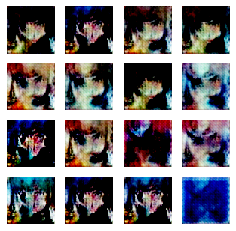

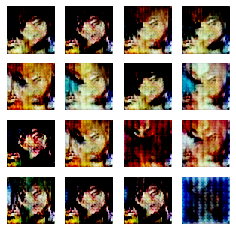

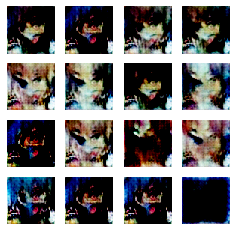

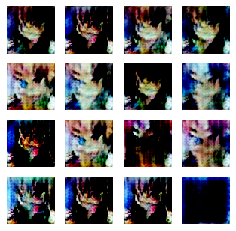

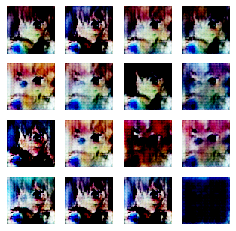

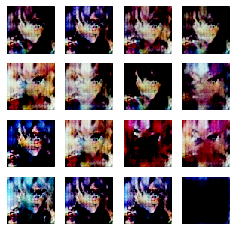

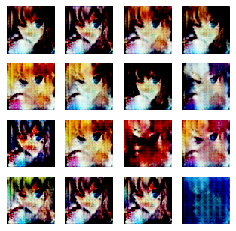

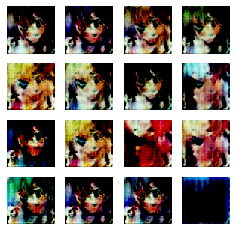

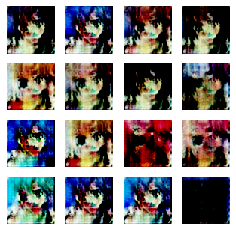

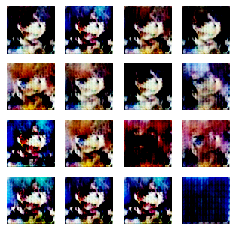

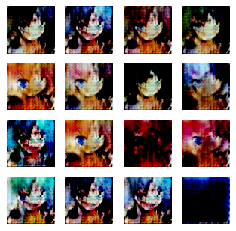

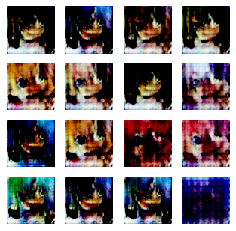

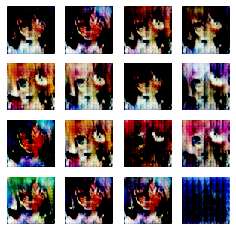

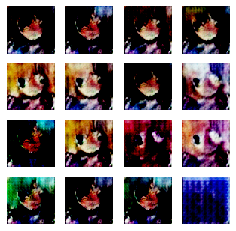

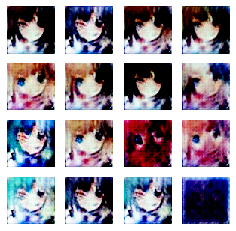

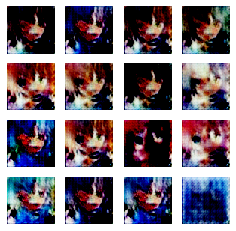

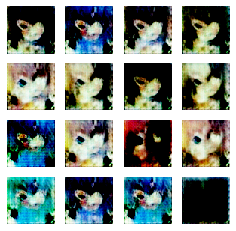

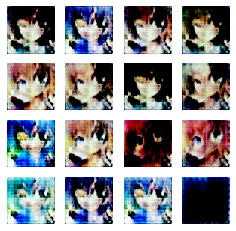

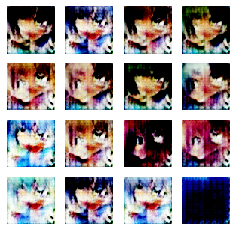

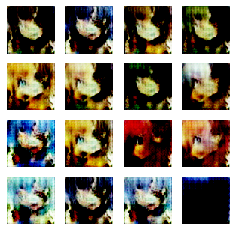

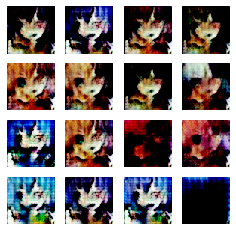

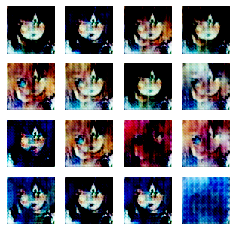

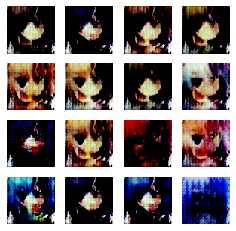

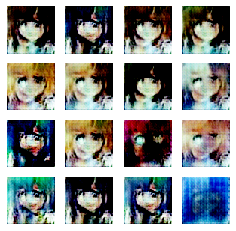

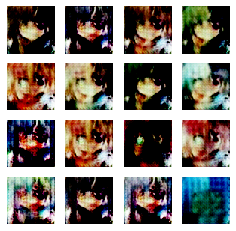

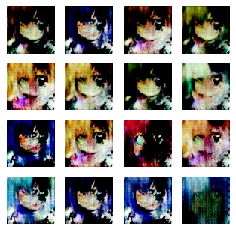

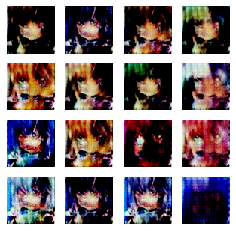

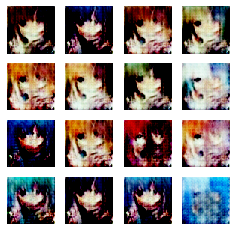

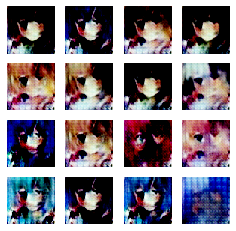

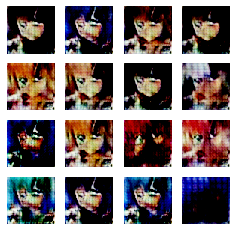

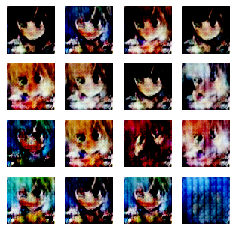

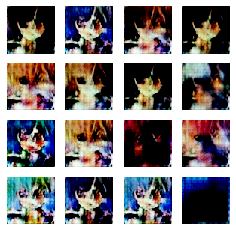

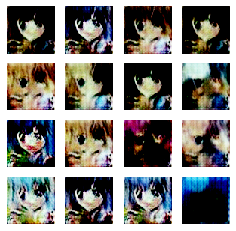

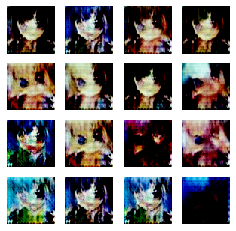

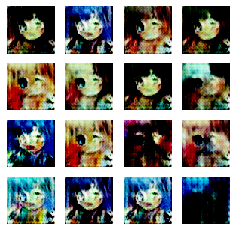

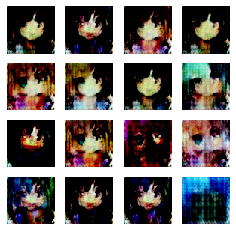

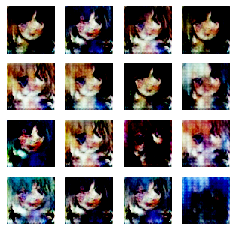

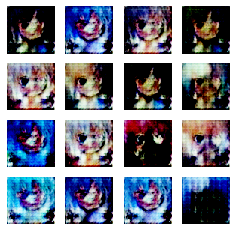

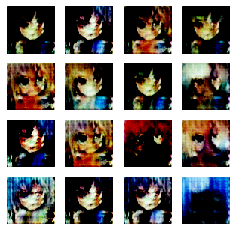

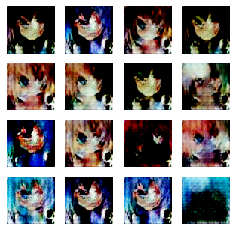

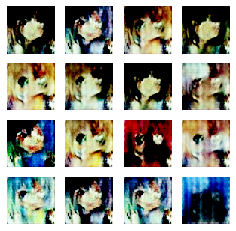

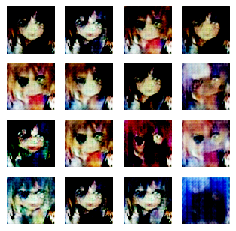

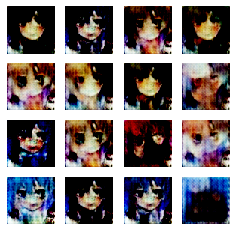

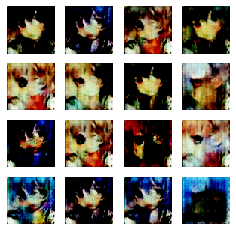

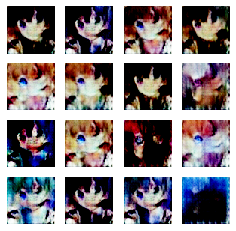

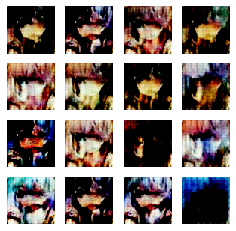

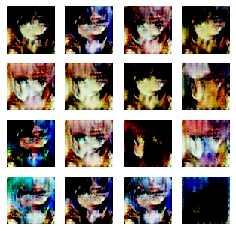

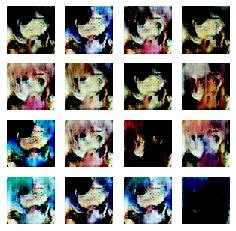

Error in callback <function flush_figures at 0x0000003F2F2CF8B8> (for post_execute):


KeyboardInterrupt: 

In [40]:
EPOCHS = 50
train(dataset, EPOCHS)

In [41]:
generator.save('./save/wgan_cartoon.h5')

## 生成

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

def generate_and_save_images(model, test_input):
    # 注意 training` 设定为 False
    # 因此，所有层都在推理模式下运行（batchnorm）
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    
    mengceng = tf.ones([64,64,3])
    
    plt.imshow((predictions[0, :, :, :] +mengceng)/2.0)

    plt.show()

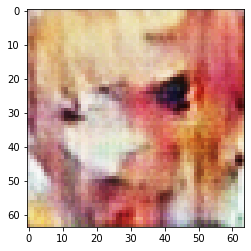

In [47]:
test_input = tf.random.uniform([1, 100],minval=-1,maxval=1,dtype=tf.float32)

model = tf.keras.models.load_model('./save/wgan_cartoon.h5')

generate_and_save_images(model, test_input)